In [71]:
import nibabel as nib
import numpy as np
import os
import glob
import h5py
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False
import json
import pandas as pd
import seaborn as sns
import time
from scipy.stats import chisquare, wasserstein_distance
import torch
import torch.nn.functional as F
from math import exp
import numpy as np
import scipy.ndimage as ndimage
import skimage
import piq

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']
color_roi_mapping = {
    "cerebellum": '#1f77b4',
    "cortex": '#ff7f0e',
    "cerebral_white_matter": '#2ca02c',
    "hippocampus": '#d62728',
    "thalamus": 'maroon',
    "caudate": '#9467bd',
    "putamen": '#8c564b', 
    "brain_stem": '#e377c2',
    "globus_pallidus": '#7f7f7f',
    "amygdala": '#bcbd22',
    "CSF": '#17becf',
    "corpus_callosum": 'lightblue'
}
TARGET_ROIS = {
        "cerebellum": [7, 8, 46, 47],
        "cortex": [3, 42],
        "cerebral_white_matter": [2, 41],
        "thalamus": [10, 49],
        "hippocampus": [17, 53],
        "caudate": [11, 50],
        "putamen": [12, 51], 
        "brain_stem": [16],
        "globus_pallidus": [13, 52],
        "amygdala": [18, 54],
        "CSF": [24],
        "corpus_callosum": [251, 252, 253, 254, 255]
    }

## ROI with lateralization
LR_ROIS = {
    "cerebellum": {'left': [7, 8], 
                   'right': [46, 47]},
    "cortex": {'left': [3],
              'right': [42]},
    "cerebral_white_matter": {'left': [2], 
                              'right':[41]},
    "hippocampus": {'left': [17],
                   'right': [53]},
    "caudate": {'left': [11],
               'right': [50]},
    "thalamus": {'left': [10],
                'right': [49]},
    "putamen": {'left': [12],
                'right': [51]}, 
    "globus_pallidus": {'left': [13],
                        'right': [52]},
    "amygdala": {'left': [18], 
                 'right': [54]},
}
## Short name for visualization purpose
Short_names = {
    "cerebral_white_matter": 'cwm',
    "cerebellum": "cb",
    "cortex": 'cortex',
    "hippocampus": "hippo",
    "caudate": "caudate",
    "thalamus": "tha",
    "putamen": "putamen",
    "globus_pallidus": "gp",
    "amygdala": "amygdala",
    "brain_stem": 'bs',
    "corpus_callosum": 'cc'
}

## Helper functions

In [72]:
def json_to_pd_row(subj, res):
    dfs = []
    for k, v in res.items():
        json_v = pd.json_normalize(v, sep='_')
        json_v['pet_type'] = k
        dfs.append(json_v)
    df = pd.concat(dfs, ignore_index=True)
    df['subject'] = subj
    col = df.pop("pet_type")
    df.insert(0, col.name, col)
    col = df.pop("subject")
    df.insert(0, col.name, col)
    return df

def plot_suvr_diff_one_subj(suvr_diff_dict, subj, ax, ignore_roi=['cerebellum'], save_name=None):
    for ignore in ignore_roi:
        if ignore in list(suvr_diff_dict.keys()):
            del suvr_diff_dict[ignore]
    preds = list(suvr_diff_dict.keys())
    # print(preds)
    all_rois = list(TARGET_ROIS.keys())
    all_names = [Short_names[x] if x in Short_names else x for x in all_rois]
    all_pred = [[] for _ in range(len(preds))]
    
    for i, pred in enumerate(preds):
        for roi in all_rois:
            pred_diff = suvr_diff_dict[pred][roi]
            all_pred[i].append(pred_diff)
            
    bar_width = 0.8 / (len(preds)+1)
    r1 = np.arange(len(all_rois))
    
    # Creating the bar plot
    colors = color_list[:len(preds)]
    labels = preds
    
    for i in range(len(all_pred)):
        r = [x + bar_width * i for x in r1]
        ax.bar(r, all_pred[i], color=colors[i], width=bar_width, edgecolor='grey', label=labels[i])
    
    # Adding the labels
    ax.set_xlabel('ROI Name', fontweight='bold')
    ax.set_xticks([r + bar_width / 2 for r in range(len(all_rois))], all_names, rotation=30, fontsize=10)

    # Adding the legend
    ax.legend()
    ax.set_title(f"SUVR Difference for Subject {subj}")

def plot_slice_visulization(subj, pred, target, roi_masks, save, slice_idx=[40, 44, 48], target_rois=['cerebral_white_matter', 'cortex']):
    # idx = target.shape[-1]//2
    nrow = len(target_rois)
    ncol = len(slice_idx)
    print(nrow, ncol)
    fig, axes = plt.subplots(2, ncol, figsize=(12, 8))
    flatten_axes = axes.flatten()
    axes_idx = 0
    used_axes_idx = []
    for idx in slice_idx:
        pred_slice = pred[:, :, idx]
        target_slice = target[:, :, idx]
        dim_roi_mask_comb = np.zeros(target_slice.shape)
        for roi in target_rois:
            roi_mask_slice = roi_masks[roi][:, :, idx]
            dim_roi_mask = np.where(roi_mask_slice==1, 1, 0)
            dim_roi_mask_comb += dim_roi_mask

        target_img = dim_roi_mask_comb * target_slice 
        pred_img = dim_roi_mask_comb * pred_slice

        flatten_axes[axes_idx].imshow(pred_img, cmap='gray')
        flatten_axes[axes_idx].set_title(f"Slice {idx} Pred")
        flatten_axes[axes_idx].axis("off")
        used_axes_idx.append(axes_idx)

        flatten_axes[axes_idx + ncol].imshow(target_img, cmap='gray')
        flatten_axes[axes_idx + ncol].set_title(f"Slice {idx} Target")
        flatten_axes[axes_idx + ncol].axis("off")
        used_axes_idx.append(axes_idx + ncol)
        axes_idx += 1
    for j in range(len(axes)):
        if j not in used_axes_idx:
            fig.delaxes(axes[j])
    rois = '_'.join(target_rois)
    fig.suptitle(f"{rois} Comparison Subject {subj}")
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')

def plot_asymmetry(info, subj, ax, save_name=None):
    sns.set_context("paper")
    sns.set_style("darkgrid")
    preds = list(info.keys())
    # print(preds)
    all_rois = list(LR_ROIS.keys())
    all_names = [Short_names[x] for x in all_rois]
    all_pred = [[] for _ in range(len(preds))]

    for i, pred in enumerate(preds):
        for roi in all_rois:
            pred_diff = info[pred][roi]['diff']
            all_pred[i].append(pred_diff)
    
    # print(all_rois, all_pred)

    bar_width = 0.8 / (len(preds)+1)
    r1 = np.arange(len(all_rois))
    
    # Creating the bar plot
    colors = color_list[:len(preds)]
    labels = preds
    
    for i in range(len(all_pred)):
        r = [x + bar_width * i for x in r1]
        ax.bar(r, all_pred[i], color=colors[i], width=bar_width, edgecolor='grey', label=labels[i])
    
    # Adding the labels
    ax.set_xlabel('ROI Name', fontweight='bold')
    ax.set_xticks([r + bar_width / 2 for r in range(len(all_rois))], all_names, rotation=30, fontsize=10)
    # Adding the legend
    ax.legend()
    ax.set_title(f"SUVR Asymmetry for Subject {subj}")
    # if save_name:
    #     plt.tight_layout()
    #     plt.savefig(save_name, bbox_inches='tight', dpi=400)
    # else:
    #     plt.show()
    # return fig


def gather_files(subj, test_dir, test_type):
    seg_file = os.path.join("/data/jiaqiw01/PET_MRI/data/segmentation", subj, "aseg.nii")
    roi_masks_global = compute_masks(seg_file)
    roi_masks_left_right = compute_hemispheric_masks(seg_file)
    pet_truth = sorted(glob.glob(os.path.join("/data/jiaqiw01/preprocessed_cases", subj, 'reslice_PET_full.nii')))
    if len(pet_truth) == 0:
        pet_truth = sorted(glob.glob(os.path.join("/data/jiahong/data/FDG_PET_preprocessed", subj, 'reslice_PET_*.nii')))
        
    pet_truth = pet_truth[0]
    print(pet_truth)
    pets = {'truth': nib.load(pet_truth).get_fdata()}
    # normalize to 0-1
    temp = np.zeros((256, 256, 89))
    temp[:, :, 20:71] = pets['truth'][:, :, 20:71]
    pets['truth'] = norm(temp)
    
    # idx = 1
    all_data = {}
    pet_data = list(glob.glob(os.path.join(test_dir, subj) + "/*.nii"))
    if pet_data == []:
        print(f"Could not find predicted pet file for {subj}")
        exit(0)
    curr_pred_pet = nib.load(pet_data[0]).get_fdata()
    if curr_pred_pet.shape != (256, 256, 89):
        padded = np.zeros((256, 256, 89))
        padded[:, :, 20:71] = curr_pred_pet
        curr_pred_pet = padded
    else:
        temp = np.zeros((256, 256, 89))
        temp[:, :, 20:71] = curr_pred_pet[:, :, 20:71]
    # normalize to 0-1
    pets[test_type] = norm(curr_pred_pet) 
    return pets, roi_masks_global, roi_masks_left_right


def norm(img, norm_type='max'):
    if norm_type == 'max':
        img = (img - img.min()) / (img.max() - img.min())
        img = np.clip(img, a_min=0, a_max=1.0)
    elif norm_type == 'mean':
        img = img / img.mean()
    return img

def compute_msssim(img1, img2):
    '''
        More accurate SSIM evaluation than skimage
    '''
    ms_ssim_index = piq.multi_scale_ssim(img1, img2, data_range=1.)
    return ms_ssim_index

def compute_roi_mask(roi_volume_labels, label_vol, shape=(256, 256, 89)):
    roi_mask = np.zeros(shape)
    for lab in roi_volume_labels:
        m = np.where(label_vol==lab, 1, 0)
        roi_mask = m + roi_mask
    return roi_mask


def compute_masks(seg_file, threshold=900):
    '''
        Mask combine left & right hemisphere
    '''
    label_vol = nib.load(seg_file).get_fdata()

    target_volume_maps = {}
    for roi in TARGET_ROIS.keys():
        val = compute_roi_mask(TARGET_ROIS[roi], label_vol)
        target_volume_maps[roi] = val
    return target_volume_maps

def compute_hemispheric_masks(seg_file):
    '''
        Separate left & right mask
        return format: 
        {
            'cerebellum': {'left': mask1, 'right': mask2},
            'thalamus': {'left', ... 'right': ...},
            .....
        }
    '''
    label_vol = nib.load(seg_file).get_fdata()
    target_rois = {
            "cerebellum": {'left': [7, 8], 
                           'right': [46, 47]},
            "cortex": {'left': [3],
                      'right': [42]},
            "cerebral_white_matter": {'left': [2], 
                                      'right':[41]},
            "hippocampus": {'left': [17],
                           'right': [53]},
            "caudate": {'left': [11],
                       'right': [50]},
            "thalamus": {'left': [10],
                        'right': [49]},
            "putamen": {'left': [12],
                        'right': [51]}, 
            "globus_pallidus": {'left': [13],
                                'right': [52]},
            "amygdala": {'left': [18], 
                         'right': [54]},
        }
    roi_maps = {}
    for roi in target_rois.keys():
        roi_maps[roi] = {'left': compute_roi_mask(target_rois[roi]['left'], label_vol),
                        'right': compute_roi_mask(target_rois[roi]['right'], label_vol)}
    return roi_maps


In [120]:
def global_bland_altman(combined_df, suffix, target_pet_type, true_pet_type, shared_rois, save_name):
    '''
        Bland altman for ROIs, taking a dataframe
        suffix: _suvr or _diff
        _diff is for SUVR asymmetry assessment
        _suvr is for SUVR assessment
    '''
    target_cols = [x+suffix for x in shared_rois]
    pet_pred_df = combined_df[combined_df['pet_type'] == target_pet_type].sort_values(by=['subject'])[target_cols]
    pet_true_df = combined_df[combined_df['pet_type'] == true_pet_type].sort_values(by=['subject'])[target_cols]
    suvr_dict_gt_list = []
    suvr_dict_pred_list = []
    suvr_dict_gt = {}
    suvr_dict_pred = {}
    for roi in shared_rois:
        col_val = pet_pred_df[roi+suffix].values
        suvr_dict_pred[roi] = col_val
        suvr_dict_pred_list.extend(col_val)
        col_val = pet_true_df[roi+suffix].values
        suvr_dict_gt[roi] = col_val
        suvr_dict_gt_list.extend(col_val)
        
    # color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']
    plt.figure(figsize=(8,6))
    
    for i, lab in enumerate(suvr_dict_gt.keys()):
        # print(suvr_dict_gt[lab], suvr_dict_pred[lab])
        plt.plot(0.5*(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab]), '.', alpha=0.6, color=color_roi_mapping[lab], label=lab, markersize=10)
    
    sd196 = round(1.96*np.std(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    mean = round(np.mean(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    xmin = round(0.5*np.min(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    xmax = round(0.5*np.max(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    plt.plot([xmin, xmax], [mean+sd196, mean+sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax-0.05, mean+sd196+0.02, "%.2f" % (mean+sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean-sd196, mean-sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax-0.05, mean-sd196+0.02, "%.2f" % (mean-sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean, mean], color='tab:purple', linestyle='dotted')
    plt.legend(ncol=2)
    plt.text(xmax-0.05, mean+0.02, "%.2f" % mean, fontsize=10)
    plt.xlabel('Mean of methods', fontsize=14)
    plt.ylabel('Acquired - Synthesized SUVR', fontsize=14)
    # plt.savefig('global_bland_altman.png')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Adjust the plot to make room for the legend
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    else:
        plt.show()


def compute_suvr(roi_masks, ref_name, pet, include_diff=True): # {pet1: {roi1: {'suvr': xx, ...}}, pet2: {roi1: {'suvr': xx}}}
    ref_mask = roi_masks[ref_name]
    if type(pet) == dict:
        res = {}
        res_diff = {}
        pet_data = pet['truth']
        res['truth'] = {}
        suv_ref = (pet_data * ref_mask).sum() / ref_mask.sum() # cerebellum total suv / cerebellum total volume
        for roi in roi_masks.keys():
            curr_roi_mask = roi_masks[roi]
            suv_roi = (pet_data * curr_roi_mask).sum() / curr_roi_mask.sum() # roi total suv / roi total volume
            suvr_roi = suv_roi / (suv_ref + 1e-5)
            res['truth'][roi] = {'suvr': suvr_roi}
        for p in pet.keys():
            if p == 'truth':
                continue
            res[p] = {}
            pet_data = pet[p]
            suv_ref = (pet_data * ref_mask).sum() / ref_mask.sum() # cerebellum total suv / cerebellum total volume
            for roi in roi_masks.keys():
                curr_roi_mask = roi_masks[roi]
                suv_roi = (pet_data * curr_roi_mask).sum() / curr_roi_mask.sum() # roi total suv / roi total volume
                suvr_roi = suv_roi / (suv_ref + 1e-5)
                res[p][roi] = {'suvr': suvr_roi}
                if include_diff:
                    if p not in res_diff:
                        res_diff[p] = {}
                    res_diff[p][roi] = res['truth'][roi]['suvr'] - suvr_roi # how suvr deviates from the true pet
        return res, res_diff
    else:
        raise NotImplementedError
    
def compute_metrics(all_pets):
    res = {}
    truth = all_pets['truth'][:, :, 20:71]
    for pet in all_pets.keys():
        if pet == 'truth':
            continue
        curr_pred_img = all_pets[pet][:, :, 20:71]
        psnr = skimage.metrics.peak_signal_noise_ratio(truth, curr_pred_img, data_range=1)
        ssim = skimage.metrics.structural_similarity(truth, curr_pred_img, data_range=1)
        rmse = skimage.metrics.normalized_root_mse(truth, curr_pred_img)

        slice_true_torch = torch.Tensor(truth).unsqueeze(0).permute(3, 0, 1, 2)
        slice_pred_torch = torch.Tensor(curr_pred_img).unsqueeze(0).permute(3, 0, 1, 2)
        msssim = piq.multi_scale_ssim(slice_true_torch, slice_pred_torch, data_range=1.)
        res[pet] = {'psnr': psnr, 'rmse': rmse, 'ssim': ssim, 'msssim': msssim}
        print(f"PET: {pet}, PSNR: {psnr}, MSSSIM: {msssim}, RMSE: {rmse}, SSIM: {ssim}")
    return res

def get_asymmetry_index(info_dict):
    '''
        Asymmetry index per subject
    '''
    true_asym = info_dict['truth']
    res = {}
    for pet_type in list(info_dict.keys()):
        if pet_type == 'truth':
            continue
        pred_asym = info_dict[pet_type]
        correct = 0
        incorrect = 0
        for roi in true_asym.keys():
            true_asym_roi = true_asym[roi]['diff']
            pred_asym_roi = pred_asym[roi]['diff']
            # check if they have the same sign
            if true_asym_roi * pred_asym_roi > 0:
                correct += 1
            else:
                incorrect += 1
        res[pet_type] = correct / (correct + incorrect)
    return res
        


def compute_asymmetry(hemisphere_roi_masks, global_roi_masks, pet, include_diff=True, ref_name='cerebellum'):
    ref_mask = global_roi_masks[ref_name]
    res = {}
    pet_data = pet['truth']
    res['truth'] = {}
    res_diff = {}
    suv_ref_global = (pet_data * ref_mask).sum() / ref_mask.sum() # global reference, i.e., both left & right cerebellum
    for roi in hemisphere_roi_masks.keys():
        curr_roi_mask_left = hemisphere_roi_masks[roi]['left']
        curr_roi_mask_right = hemisphere_roi_masks[roi]['right']
        suv_roi_left = (pet_data * curr_roi_mask_left).sum() / curr_roi_mask_left.sum() # roi total suv / roi total volume
        suvr_roi_left = suv_roi_left / (suv_ref_global + 1e-4)
        
        suv_roi_right = (pet_data * curr_roi_mask_right).sum() / curr_roi_mask_right.sum() # roi total suv / roi total volume
        suvr_roi_right = suv_roi_right / (suv_ref_global + 1e-4)
        
        res['truth'][roi] = {'left': suvr_roi_left,
                            'right': suvr_roi_right,
                            'diff': (suvr_roi_left - suvr_roi_right) / (suvr_roi_left + suvr_roi_right)}
    for p in pet.keys():
        if p == 'truth':
            continue
        res[p] = {}
        pet_data = pet[p]
        suv_ref_global = (pet_data * ref_mask).sum() / ref_mask.sum() # cerebellum total suv / cerebellum total volume
        for roi in hemisphere_roi_masks.keys():
            curr_roi_mask_left = hemisphere_roi_masks[roi]['left']
            curr_roi_mask_right = hemisphere_roi_masks[roi]['right']
            suv_roi_left = (pet_data * curr_roi_mask_left).sum() / curr_roi_mask_left.sum() # roi total suv / roi total volume
            suvr_roi_left = suv_roi_left / (suv_ref_global + 1e-4)
            
            suv_roi_right = (pet_data * curr_roi_mask_right).sum() / curr_roi_mask_right.sum() # roi total suv / roi total volume
            suvr_roi_right = suv_roi_right / (suv_ref_global + 1e-4)
            res[p][roi] = {'left': suvr_roi_left,
                           'right': suvr_roi_right,
                           'diff': (suvr_roi_left - suvr_roi_right) / (suvr_roi_left + suvr_roi_right)}
            if include_diff:
                if p not in res_diff:
                    res_diff[p] = {}
                res_diff[p][roi] = {'left': res['truth'][roi]['left'] - res[p][roi]['left'],
                                   'right': res['truth'][roi]['right'] - res[p][roi]['right'],
                                    'diff': res['truth'][roi]['diff'] - res[p][roi]['diff'],
                                   }
    asym_index = get_asymmetry_index(res)
    
    return res, res_diff


def get_histogram(data, num_bins=64, scale=10, output='norm'):
     # calculate histogram
    histograms, _ = np.histogram(data, bins=num_bins, range=(0.001, 1))
    normalized_histograms = histograms / (histograms.sum(keepdims=True) + 1e-4)
    normalized_histograms *= scale
    if output == 'norm':
        return normalized_histograms
    cum_hist = np.cumsum(normalized_histograms)
    hist_diff = np.diff(normalized_histograms)
    hist_diff = np.insert(hist_diff, 0, hist_diff[0])
    hist_diff *= scale
    combined_histogram = np.stack((normalized_histograms, cum_hist, hist_diff), axis=0) # 3, 128
    # assert combined_histogram.shape == (3, 128)
    return combined_histogram
    
def compare_histograms_w_plot_asym(vol1, vol2, roi_name, pet_type, hist_truth_left, hist_truth_right, emd_truth, axes, num_bins=128):
    '''
        Evaluate histogram with Wasserstein loss, can be a single slice or a whole volume
    '''
    hist1 = get_histogram(vol1, num_bins, output='all')[0]
    hist2 = get_histogram(vol2, num_bins, output='all')[0]
    emd = wasserstein_distance(hist1, hist2)
    emd_diff = emd_truth - emd
    if axes is not None:
        axes[0].bar(range(num_bins), hist1, width=3, label=roi_name+'_pred')
        axes[1].bar(range(num_bins), hist2, width=3, label=roi_name+'_pred')
        axes[2].bar(range(num_bins), hist_truth_left, width=3, label=roi_name)
        axes[3].bar(range(num_bins), hist_truth_right, width=3, label=roi_name)
    # plt.suptitle(f"{pet_type} {roi_name} Asymmetry Wasserstein {emd} VS {emd_truth}")
    # Wasserstein distance
    print(f'{pet_type} {roi_name} EMD: {emd}')
    return emd, emd_diff

def compare_histogram_asymmetry(roi_masks, pets, target_rois, axes, num_bins=128):
    res = {}
    res_diff = {}
    for roi in target_rois:
        val = roi_masks[roi]
        roi_mask_left = val['left']
        roi_mask_right = val['right']
        hist_truth_left = get_histogram(pets['truth'] * roi_mask_left, num_bins=num_bins)
        hist_truth_right = get_histogram(pets['truth'] * roi_mask_right, num_bins=num_bins)
        emd_truth = wasserstein_distance(hist_truth_left, hist_truth_right)
        for pet_type, pet_vol in pets.items():
            if pet_type not in res:
                res[pet_type] = {}
                res_diff[pet_type] = {}
            if pet_type == 'truth':
                continue
            vol_left = pet_vol * roi_mask_left
            vol_right = pet_vol * roi_mask_right
            emd, emd_diff = compare_histograms_w_plot_asym(vol_left, vol_right, roi, pet_type, hist_truth_left, hist_truth_right, emd_truth, axes)
            res[pet_type][roi] = emd
            res_diff[pet_type][roi] = emd_diff
    return res, res_diff

def compare_histogram_roi(roi_masks, pets, target_rois, axes=None, num_bins=128):
    res = {}
    for i, roi in enumerate(target_rois):
        m = roi_masks[roi]
        hist_truth = get_histogram(pets['truth'] * m, num_bins=num_bins)
        for pet_type, pet_vol in pets.items():
            if pet_type == 'truth':
                continue
            if pet_type not in res:
                res[pet_type] = {}
            curr_hist = get_histogram(pet_vol * m, num_bins=num_bins)
            if axes is not None:
                axes[i].bar(range(num_bins), hist_truth, width=3, label=roi+'_acq', color='red')
                axes[i].bar(range(num_bins), curr_hist, width=3, label=roi+'_synth', color='blue')
            emd = wasserstein_distance(hist_truth, curr_hist)
            res[pet_type] = emd
    return res
    
    

def analyze_one_subj(subj, pet_types, save_dest, *test_dirs):
    '''
        Computes SUVR, PSNR, RMSE, MSSSIM, SUVR-asymmetry, histogram-asymmetry
    '''
    seg_file = os.path.join("/data/jiaqiw01/PET_MRI/data/segmentation", subj, "aseg.nii")
    roi_masks_global = compute_masks(seg_file)
    roi_masks_left_right = compute_hemispheric_masks(seg_file)
    pet_truth = sorted(glob.glob(os.path.join("/data/jiaqiw01/preprocessed_cases", subj, 'reslice_PET_full.nii')))
    if len(pet_truth) == 0:
        pet_truth = sorted(glob.glob(os.path.join("/data/jiahong/data/FDG_PET_preprocessed", subj, 'reslice_PET_*.nii')))
        
    pet_truth = pet_truth[0]
    print(pet_truth)
    pets = {'truth': nib.load(pet_truth).get_fdata()}
    # normalize to 0-1
    temp = np.zeros((256, 256, 89))
    temp[:, :, 20:71] = pets['truth'][:, :, 20:71]
    pets['truth'] = norm(temp)

    fig3, axes = plt.subplots(nrows=len(test_subjects), ncols=4, figsize=(15, 25))
    axes_flatten_histogram = axes.ravel()
    
    # idx = 1
    for i, directory in enumerate(test_dirs):
        pet_data = list(glob.glob(os.path.join(directory, subj) + "/*.nii"))
        if pet_data == []:
            print(f"Could not find predicted pet file for {subj}")
            continue
        curr_pred_pet = nib.load(pet_data[0]).get_fdata()
        if curr_pred_pet.shape != (256, 256, 89):
            padded = np.zeros((256, 256, 89))
            padded[:, :, 20:71] = curr_pred_pet
            curr_pred_pet = padded
        else:
            temp = np.zeros((256, 256, 89))
            temp[:, :, 20:71] = curr_pred_pet[:, :, 20:71]
        # normalize to 0-1
        pets[pet_types[i]] = norm(curr_pred_pet)
        # fname = f'{save_dest}/{subj}_{pet_types[i]}_slice_visualization.png'
        # print("====Plotting Slice Visualization====")
        # plot_slice_visulization(subj, curr_pred_pet, pets['truth'], roi_masks, fname)

    suvr, suvr_diff = compute_suvr(roi_masks_global, 'cerebellum', pets, include_diff=True)
    all_metrics = compute_metrics(pets)
    suvr_hemi_diff, suvr_hemi_diff_diff = compute_asymmetry(roi_masks_left_right, roi_masks_global, pets)
    target_rois = ['thalamus', 'hippocampus', 'putamen']
    emd_roi = compare_histogram_roi(roi_masks_global, pets, target_rois)
                                    
    return suvr, suvr_diff, all_metrics, suvr_hemi_diff, suvr_hemi_diff_diff, emd_roi


In [133]:
def prepare_all_subjects(test_subjects, test_dirs, exp_types, save_dest):
    all_suvr_diff_df = []
    all_asym_df = []
    all_emd_df = []
    all_suvr_df = []
    all_subj_metrics = {}
    all_subj_suvr_diff = {}
    all_subj_asym_diff = {}

    fig1, axes = plt.subplots(nrows=4, ncols=len(test_subjects)//4 + 1, figsize=(15,25))
    axes_flatten_asym = axes.ravel()

    fig2, axes = plt.subplots(nrows=4, ncols=len(test_subjects)//4 + 1, figsize=(15, 25))
    axes_flatten_suvr = axes.ravel()

    
    for i, subj in enumerate(test_subjects):
        print(f"------Performing {subj}--------")
        suvr, suvr_diff, all_metrics, asym, asym_diff, emd_roi =  analyze_one_subj(subj, exp_types, save_dest, *test_dirs)
        plot_asymmetry(asym, subj, axes_flatten_asym[i])

        suvr_df = json_to_pd_row(subj, suvr)
        suvr_diff_df = json_to_pd_row(subj, suvr_diff)
        asym_df = json_to_pd_row(subj, asym)
        emd_df = json_to_pd_row(subj, emd_diff)
    
        all_suvr_diff_df.append(suvr_diff_df)
        all_suvr_df.append(suvr_df)
        all_asym_df.append(asym_df)
        all_emd_df.append(emd_df)

        all_subj_metrics[subj] = all_metrics
        all_subj_suvr_diff[subj] = suvr_diff
        plot_suvr_diff_one_subj(suvr_diff, subj, axes_flatten_suvr[i], save_name=None)
        print("------Done------")

    # Hide any unused subplots
    for j in range(i + 1, len(axes_flatten_1)):
        fig1.delaxes(axes_flatten_asym[j])
        fig2.delaxes(axes_flatten_suvr[j])
        
    plt.tight_layout()
    if save_dest:
        fig1.savefig(os.path.join(save_dest, "SUVR_Asymmetry.png"), bbox_inches='tight', dpi=300)
        fig1.savefig(os.path.join(save_dest, "SUVR_Differences.png"), bbox_inches='tight', dpi=300)
    else:
        fig1.show()
        fig2.show()
    
    if save_dest:
        with open(os.path.join(save_dest, "all_metrics.json"), 'w') as fw:
            json.dump(all_subj_metrics, fw, indent=4)
    
        with open(os.path.join(save_dest, "all_suvr_diff.json"), 'w') as fw:
            json.dump(all_subj_suvr_diff, fw, indent=4)

    combined_suvr_df = pd.concat(all_suvr_df, ignore_index=True)
    combined_asym_df = pd.concat(all_asym_df, ignore_index=True)
    combined_emd_df = pd.concat(all_emd_df, ignore_index=True)
    
    return combined_suvr_df, combined_asym_df, combined_emd_df, all_subj_metrics, all_subj_suvr_diff

## Compute metrics of your choice for 1 model

### First collect masks & different PETs

In [173]:
# define test_dir, which stores the synthetic PET based on subjects
# define experiment type, an identifier such as the model's name
test_dir = '/data/jiaqiw01/all_exp_tests/seg_guided/'
exp_type = 'seg_guided_t2f'
save_dest = f"/data/jiaqiw01/model_eval/{exp_type}"

In [174]:
test_subjects = os.listdir(test_dir)
all_subj_mask_info = {}
for i, subj in enumerate(test_subjects):
    pets, roi_mask_global, roi_mask_left_right = gather_files(subj, test_dir, exp_type)
    all_subj_mask_info[subj] = {'pets': pets,
                               'mask_global': roi_mask_global,
                               'mask_left_right': roi_mask_left_right}

/data/jiaqiw01/preprocessed_cases/25120/reslice_PET_full.nii
/data/jiaqiw01/preprocessed_cases/25131/reslice_PET_full.nii
/data/jiaqiw01/preprocessed_cases/25182/reslice_PET_full.nii
/data/jiaqiw01/preprocessed_cases/25501/reslice_PET_full.nii
/data/jiaqiw01/preprocessed_cases/25074/reslice_PET_full.nii
/data/jiaqiw01/preprocessed_cases/25013/reslice_PET_full.nii


### Compute SUVR Asymmetry & SUVR Asymmetry Histograms

### Histogram asymmetry

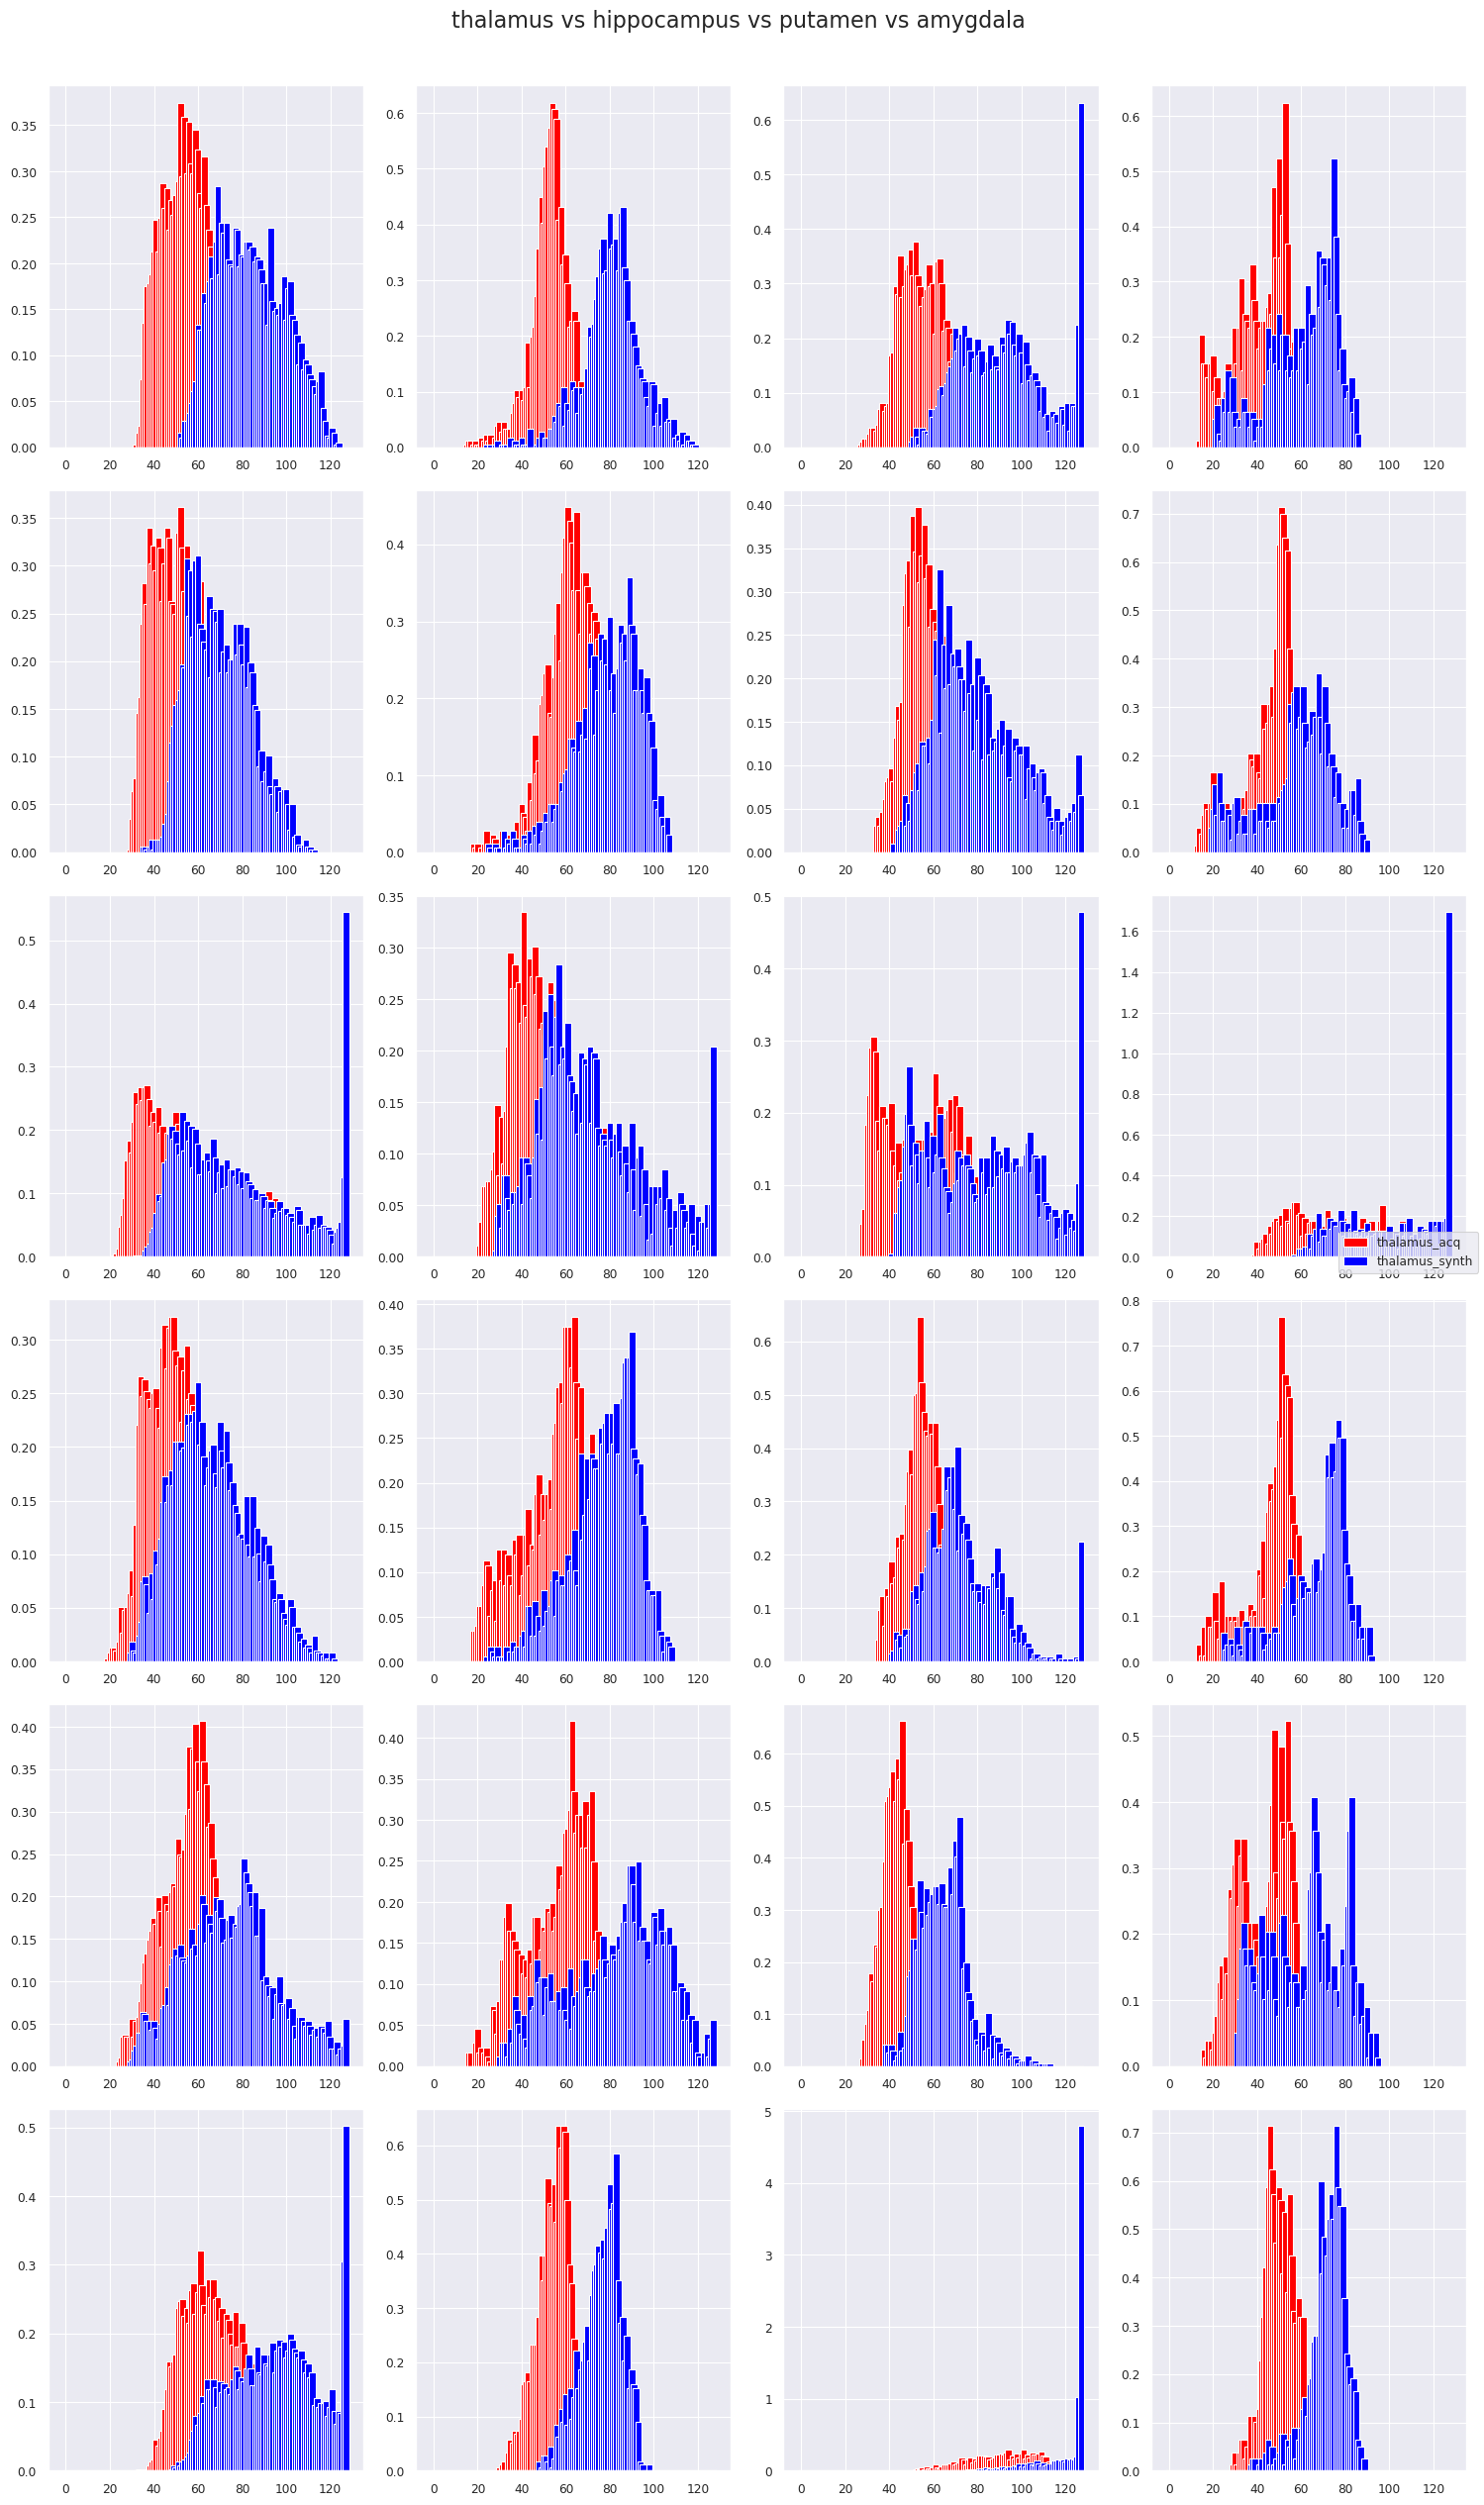

In [175]:
all_metrics = {} # {'emd': [subj1, subj2....], 'emd_diff': [subj1, subj2, ....]}
## Select some ROIs
target_rois = ['thalamus', 'hippocampus', 'putamen', 'amygdala']
nrow = len(test_subjects)
ncol = len(target_rois)
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15, 25))
axes_flatten = axes.ravel()
for i, subj in enumerate(list(all_subj_mask_info.keys())):
    content = all_subj_mask_info[subj]
    roi_masks_left_right = content['mask_left_right']
    roi_mask_global = content['mask_global']
    pets = content['pets']
    # emd, emd_diff = compare_histogram_asymmetry(roi_masks_left_right, pets, target_rois, axes_flatten[i*4:i*4+4])
    emd_roi = compare_histogram_roi(roi_masks_global, pets, target_rois, axes_flatten[i*ncol:i*ncol+ncol])
    if 'emd_roi' not in all_metrics:
        all_metrics['emd_roi'] = []
    all_metrics['emd_roi'].append(emd)
    # if i == nrow - 1:  # If it's the last row
    #     axes[i, j].set_xlabel(f'Column {j + 1}')
    
handles1, labels1 = axes_flatten[0].get_legend_handles_labels()
# handles2, labels2 = axes_flatten[2].get_legend_handles_labels()
handles = handles1
labels = labels1
fig.suptitle(" vs ".join(target_rois), y=1.01, fontsize=16)
# Add a single legend to one of the subplots or the figure
fig.legend(handles, labels, loc='right')
fig.tight_layout()
os.makedirs(save_dest, exist_ok=True)
if save_dest:
    fig.savefig(save_dest + '/roi_histogram.png', dpi=300, bbox_inches='tight')

### SUVR Asymmetry

====== SUVR Asymmetry is computed using (left - right) / (left + right) ======


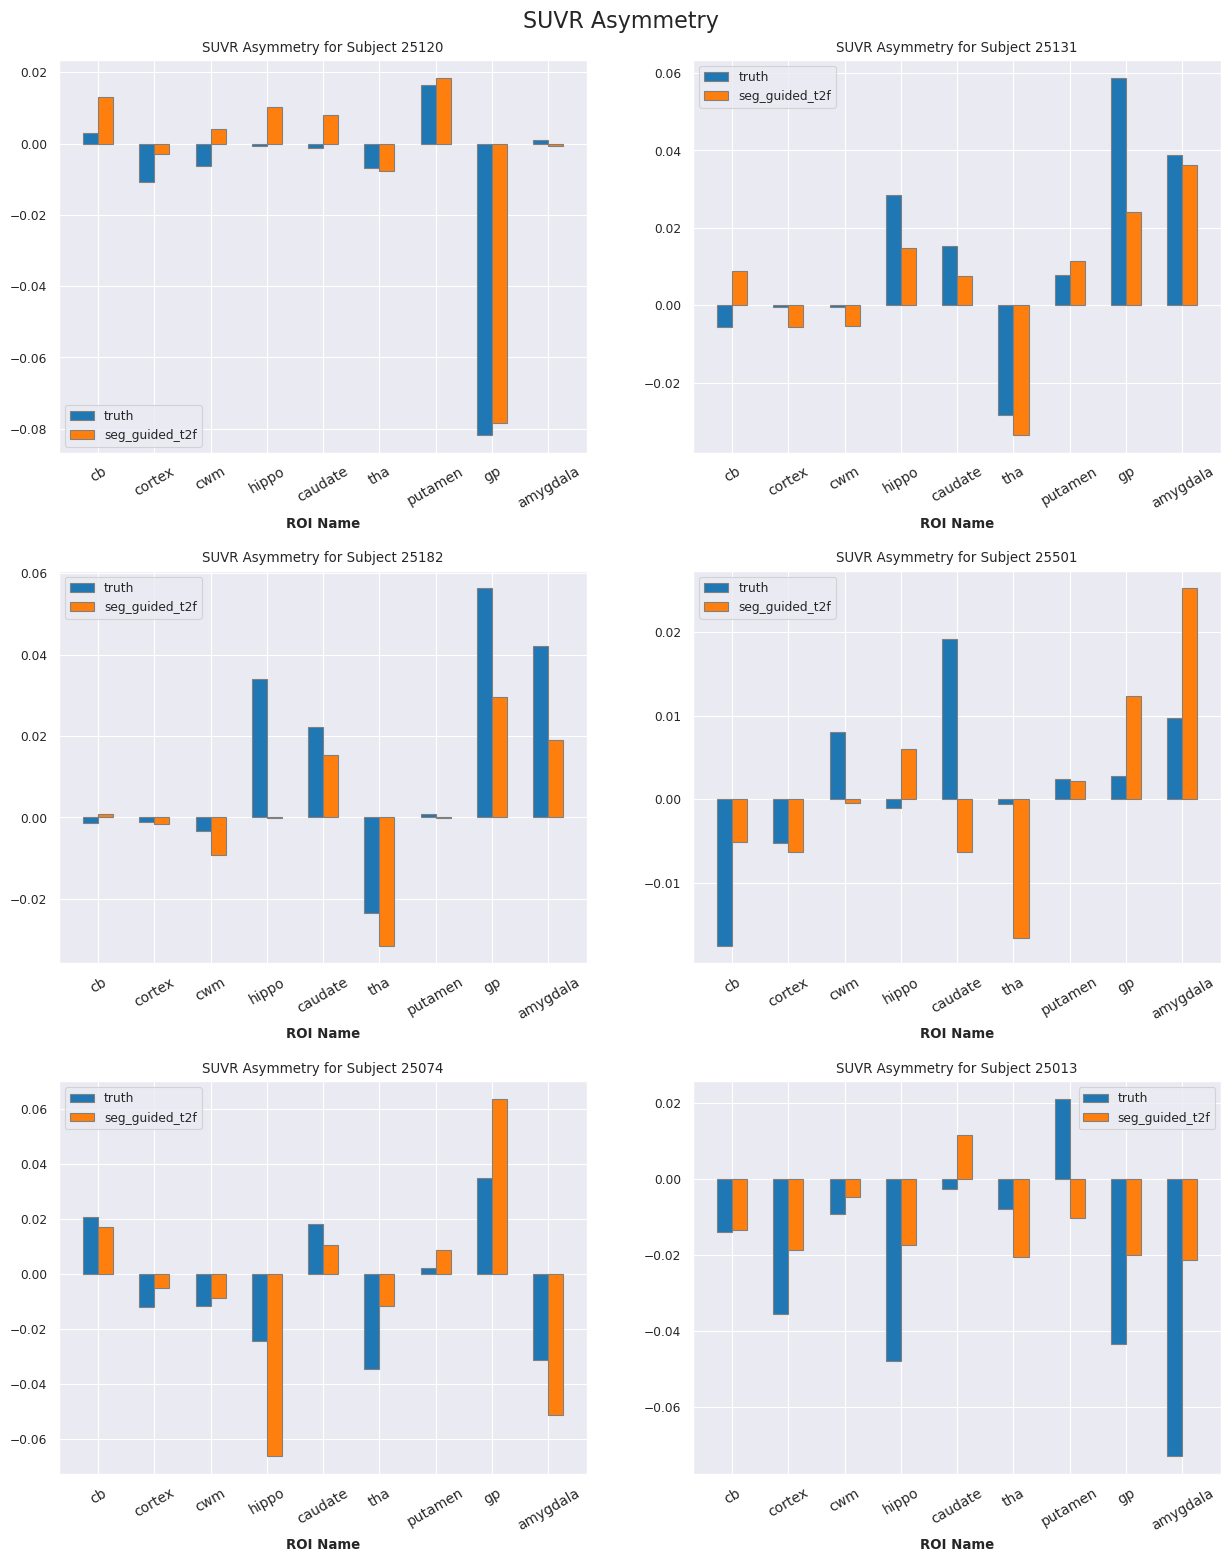

In [176]:
fig1, axes = plt.subplots(nrows=4, ncols=len(test_subjects)//4 + 1, figsize=(15,25))
axes_flatten_1 = axes.ravel()
print("====== SUVR Asymmetry is computed using (left - right) / (left + right) ======")
for i, subj in enumerate(list(all_subj_mask_info.keys())):
    # compute metrics for this subject
    content = all_subj_mask_info[subj]
    roi_masks_left_right = content['mask_left_right']
    roi_mask_global = content['mask_global']
    pets = content['pets']
    suvr_asym, suvr_asym_diff = compute_asymmetry(roi_masks_left_right, roi_mask_global, pets)
    if 'suvr_asym' not in all_metrics:
        all_metrics['suvr_asym'] = []
    if 'suvr_asym_diff' not in all_metrics:
        all_metrics['suvr_asym_diff'] = []
    all_metrics['suvr_asym'].append(suvr_asym)
    all_metrics['suvr_asym_diff'].append(suvr_asym_diff)
    plot_asymmetry(suvr_asym, subj, axes_flatten_1[i])
for j in range(i + 1, len(axes_flatten_1)):
    fig1.delaxes(axes_flatten_1[j])
fig1.suptitle("SUVR Asymmetry", y=0.9, fontsize=16)
plt.subplots_adjust(hspace=0.3)
fig1.show()
if save_dest:
    fig1.savefig(save_dest + '/suvr_asym.png', dpi=300, bbox_inches='tight')

### SUVR Difference Comparison
#### SUVR diff = acquired SUVR - synthetic SUVR

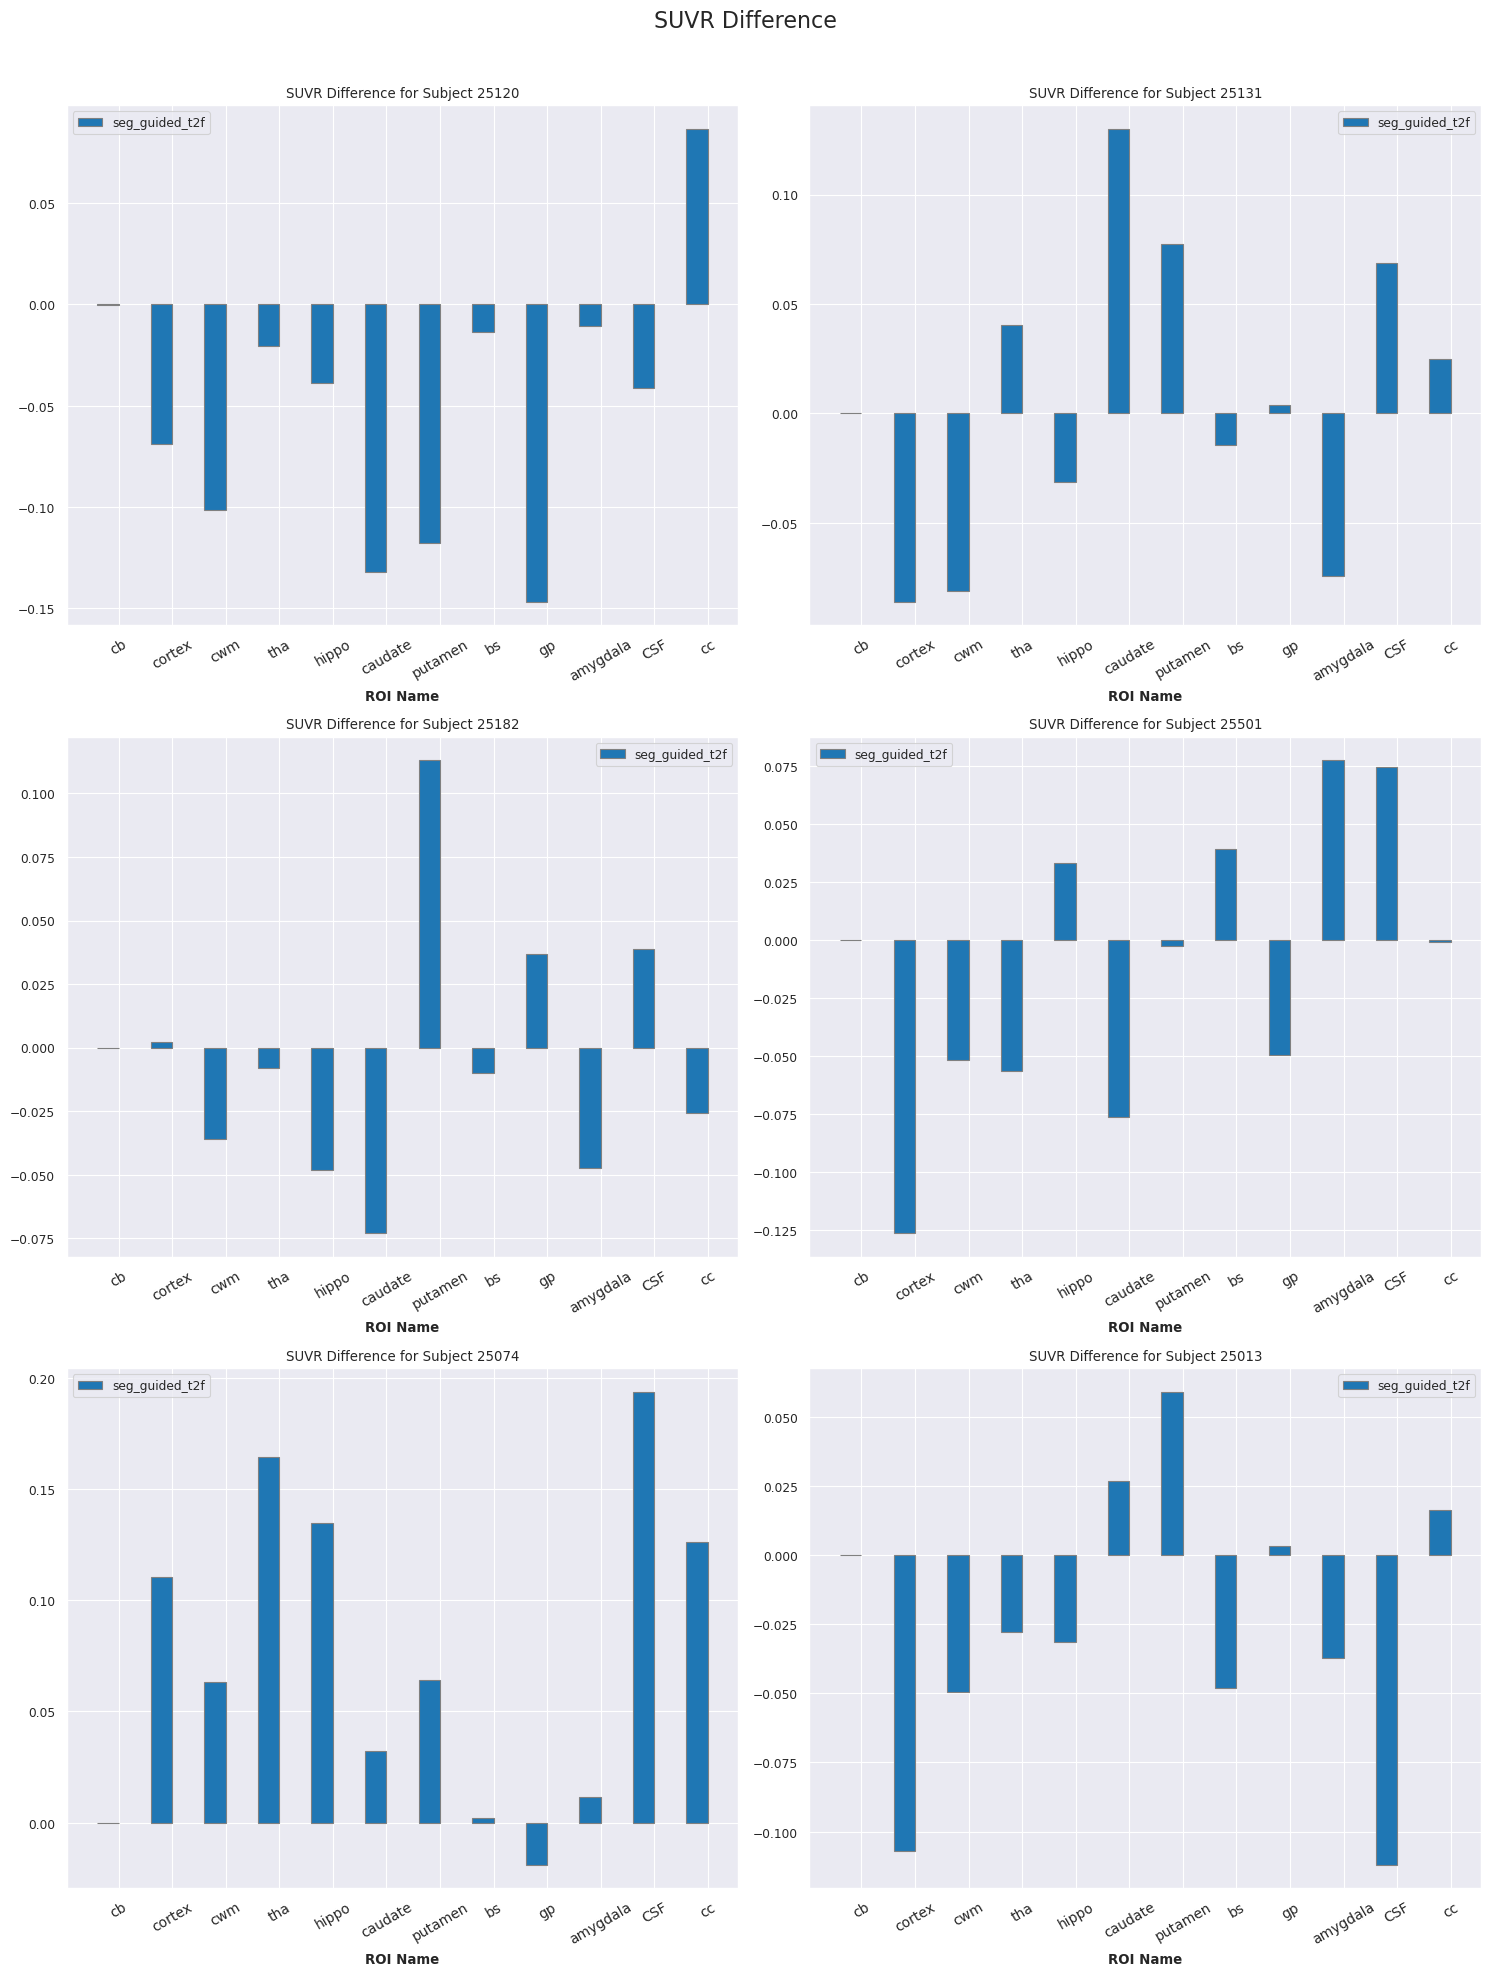

In [177]:
fig2, axes = plt.subplots(nrows=4, ncols=len(test_subjects)//4 + 1, figsize=(15, 25))
axes_flatten_2 = axes.ravel()
for i, subj in enumerate(list(all_subj_mask_info.keys())):
    # compute metrics for this subject
    content = all_subj_mask_info[subj]
    roi_masks_left_right = content['mask_left_right']
    roi_masks_global = content['mask_global']
    pets = content['pets']
    suvr, suvr_diff = compute_suvr(roi_masks_global, 'cerebellum', pets, include_diff=True)
    if 'suvr' not in all_metrics:
        all_metrics['suvr'] = []
    if 'suvr_diff' not in all_metrics:
        all_metrics['suvr_diff'] = []
    all_metrics['suvr'].append(suvr)
    all_metrics['suvr_diff'].append(suvr_diff)
    plot_suvr_diff_one_subj(suvr_diff, subj, axes_flatten_2[i], save_name=None)
for j in range(i + 1, len(axes_flatten_2)):
    fig2.delaxes(axes_flatten_2[j])
plt.subplots_adjust(hspace=0.5)
fig2.suptitle("SUVR Difference", y=1.01, fontsize=16)
plt.tight_layout()
fig2.show()
if save_dest:
    fig2.savefig(save_dest + '/suvr_difference.png', dpi=300, bbox_inches='tight')

## Get some stats summarization

In [89]:
def summarize_stats(stats_dict, targets=['emd_diff', 'suvr_asym_diff', 'suvr_diff'], exp_name=None, mode='all'): # average across all ROI
    '''
        Mode: all
        Mean & std taken wrt abs(diff)
    '''
    summary = {}
    if not exp_name:
        # use the first one
        exp_name = list(stats_dict[targets[0]][0].keys())[0]
    print(f" ======= Summarizing {exp_name} =======")
    for t in targets:
        assert t in stats_dict, f"Stats key {t} not found.... Exiting"
        vals = stats_dict[t] # [{'exp_name': {'ROI1': val}, {'ROI2': val}}, {'exp_name'}]
        curr_vals = []
        if t == 'emd_diff':
            for val in vals:
                exp_stats = val[exp_name]
                for roi, num in exp_stats.items():
                    curr_vals.append(abs(num))
        elif t == 'suvr_diff':
            for val in vals:
                exp_stats = val[exp_name]
                for roi, num in exp_stats.items():
                    if roi == 'cerebellum': # skip reference region
                        continue
                    curr_vals.append(abs(num))
        elif t == 'suvr_asym_diff':
            for val in vals:
                exp_stats = val[exp_name]
                for roi, num in exp_stats.items():
                    curr_vals.append(abs(num['diff']))
        else:
            raise NotImplementedError
        summary[t] = {'Mean': np.mean(curr_vals),
                      'std': np.std(curr_vals)}
    print(summary)
    return summary

In [91]:
all_metrics['suvr_diff']

[{'vesde_t1_t2f': {'cerebellum': -7.326453480194228e-05,
   'cortex': -0.03542997095319689,
   'cerebral_white_matter': -0.16218107808543103,
   'thalamus': 0.1252093463558187,
   'hippocampus': -0.01259263798709076,
   'caudate': 0.0013114802374920576,
   'putamen': 0.009593125639478561,
   'brain_stem': 0.06289064283714862,
   'globus_pallidus': 0.028539604238064786,
   'amygdala': 1.6863155508750616e-05,
   'CSF': -0.09030409286298846,
   'corpus_callosum': -0.06133432095996327}},
 {'vesde_t1_t2f': {'cerebellum': -4.260038569003921e-05,
   'cortex': -0.06223785456515407,
   'cerebral_white_matter': -0.19124463205710962,
   'thalamus': 0.2198884323218342,
   'hippocampus': -0.07222030613525454,
   'caudate': 0.1551268722416852,
   'putamen': 0.14299130458771692,
   'brain_stem': 0.051137616496461424,
   'globus_pallidus': 0.10232385285437084,
   'amygdala': -0.13219131992005773,
   'CSF': 0.06543578977148379,
   'corpus_callosum': -0.07917651352683297}},
 {'vesde_t1_t2f': {'cerebellu

In [92]:
all_metrics['suvr_asym_diff']

[{'vesde_t1_t2f': {'cerebellum': {'left': -0.015443942927733545,
    'right': 0.017812343598429092,
    'diff': -0.016659147564350038},
   'cortex': {'left': -0.04948849746104478,
    'right': -0.02075825407717935,
    'diff': -0.011846274670996668},
   'cerebral_white_matter': {'left': -0.18313600520109685,
    'right': -0.14061132386626607,
    'diff': -0.020442441962568097},
   'hippocampus': {'left': -0.019193835763177014,
    'right': -0.007699907309145937,
    'diff': -0.0063498275211924735},
   'caudate': {'left': -0.00796268706895864,
    'right': 0.00937835949221566,
    'diff': -0.007230194124491558},
   'thalamus': {'left': 0.0966984896672689,
    'right': 0.1549401869472199,
    'diff': -0.029521725061099895},
   'putamen': {'left': 0.015327612394751888,
    'right': 0.003499825719768257,
    'diff': 0.004335375081700399},
   'globus_pallidus': {'left': 0.004467661979097426,
    'right': 0.05341172186298193,
    'diff': -0.0211185155278256},
   'amygdala': {'left': -0.02977

In [93]:
summarize_stats(all_metrics, targets=['emd_diff', 'suvr_asym_diff', 'suvr_diff'], exp_name=exp_type)

 ======= Summarizing vesde_t1_t2f =======
{'emd_diff': {'Mean': 0.008031864167483192, 'std': 0.009992590359846554}, 'suvr_asym_diff': {'Mean': 0.020356097327325767, 'std': 0.01998584462668092}, 'suvr_diff': {'Mean': 0.0789071295472946, 'std': 0.06158006233436685}}


{'emd_diff': {'Mean': 0.008031864167483192, 'std': 0.009992590359846554},
 'suvr_asym_diff': {'Mean': 0.020356097327325767, 'std': 0.01998584462668092},
 'suvr_diff': {'Mean': 0.0789071295472946, 'std': 0.06158006233436685}}

In [103]:
def convert_to_df(all_metrics, targets=[], exp_name='vpsde_dds_step_100', save_excel=None):
    all_dfs = []
    for target in targets:
        extracted_data = [item[exp_name] for item in all_metrics[target]]
        df = pd.DataFrame(extracted_data)
        all_dfs.append(df)
    if save_excel:
        with pd.ExcelWriter(f'analysis_result_sheets.xlsx', engine='xlsxwriter', mode='a') as writer:
            # Write each DataFrame to a separate sheet
            for i, df in enumerate(all_dfs):
                df.to_excel(writer, sheet_name=f'{exp_name}_{targets[i]}_result', index=False)

## Global bland altman + multi model comparison (need to have same test subjects)
#### You can do it for both SUVR and SUVR_asymmetry
#### Currently put it in a panda dataframe to facilitate result saving

In [131]:
def collect_mutual_subjects(test_dirs):
    subj = None
    for d in test_dirs:
        test_subj = os.listdir(d)
        if not subj:
            subj = test_subj
        else:
            subj = list(set(subj) & set(test_subj))
    assert subj != [], "Could not find any mutual test subjects....."
    return subj

------Performing 25120--------
/data/jiaqiw01/preprocessed_cases/25120/reslice_PET_full.nii
PET: seg_guided_t2f, PSNR: 20.87795163904969, MSSSIM: 0.906052827835083, RMSE: 0.6004653678186793, SSIM: 0.7844758903618771
------Done------
------Performing 25131--------
/data/jiaqiw01/preprocessed_cases/25131/reslice_PET_full.nii
PET: seg_guided_t2f, PSNR: 24.518786676183275, MSSSIM: 0.9492775201797485, RMSE: 0.2943700120461097, SSIM: 0.7978208461504813
------Done------
------Performing 25182--------
/data/jiaqiw01/preprocessed_cases/25182/reslice_PET_full.nii
PET: seg_guided_t2f, PSNR: 21.798736943084855, MSSSIM: 0.9360584020614624, RMSE: 0.4583400595570462, SSIM: 0.7847418684024855
------Done------
------Performing 25501--------
/data/jiaqiw01/preprocessed_cases/25501/reslice_PET_full.nii
PET: seg_guided_t2f, PSNR: 22.56523372685242, MSSSIM: 0.9383270144462585, RMSE: 0.4034078544071266, SSIM: 0.7782254114617344
------Done------
------Performing 25074--------
/data/jiaqiw01/preprocessed_case

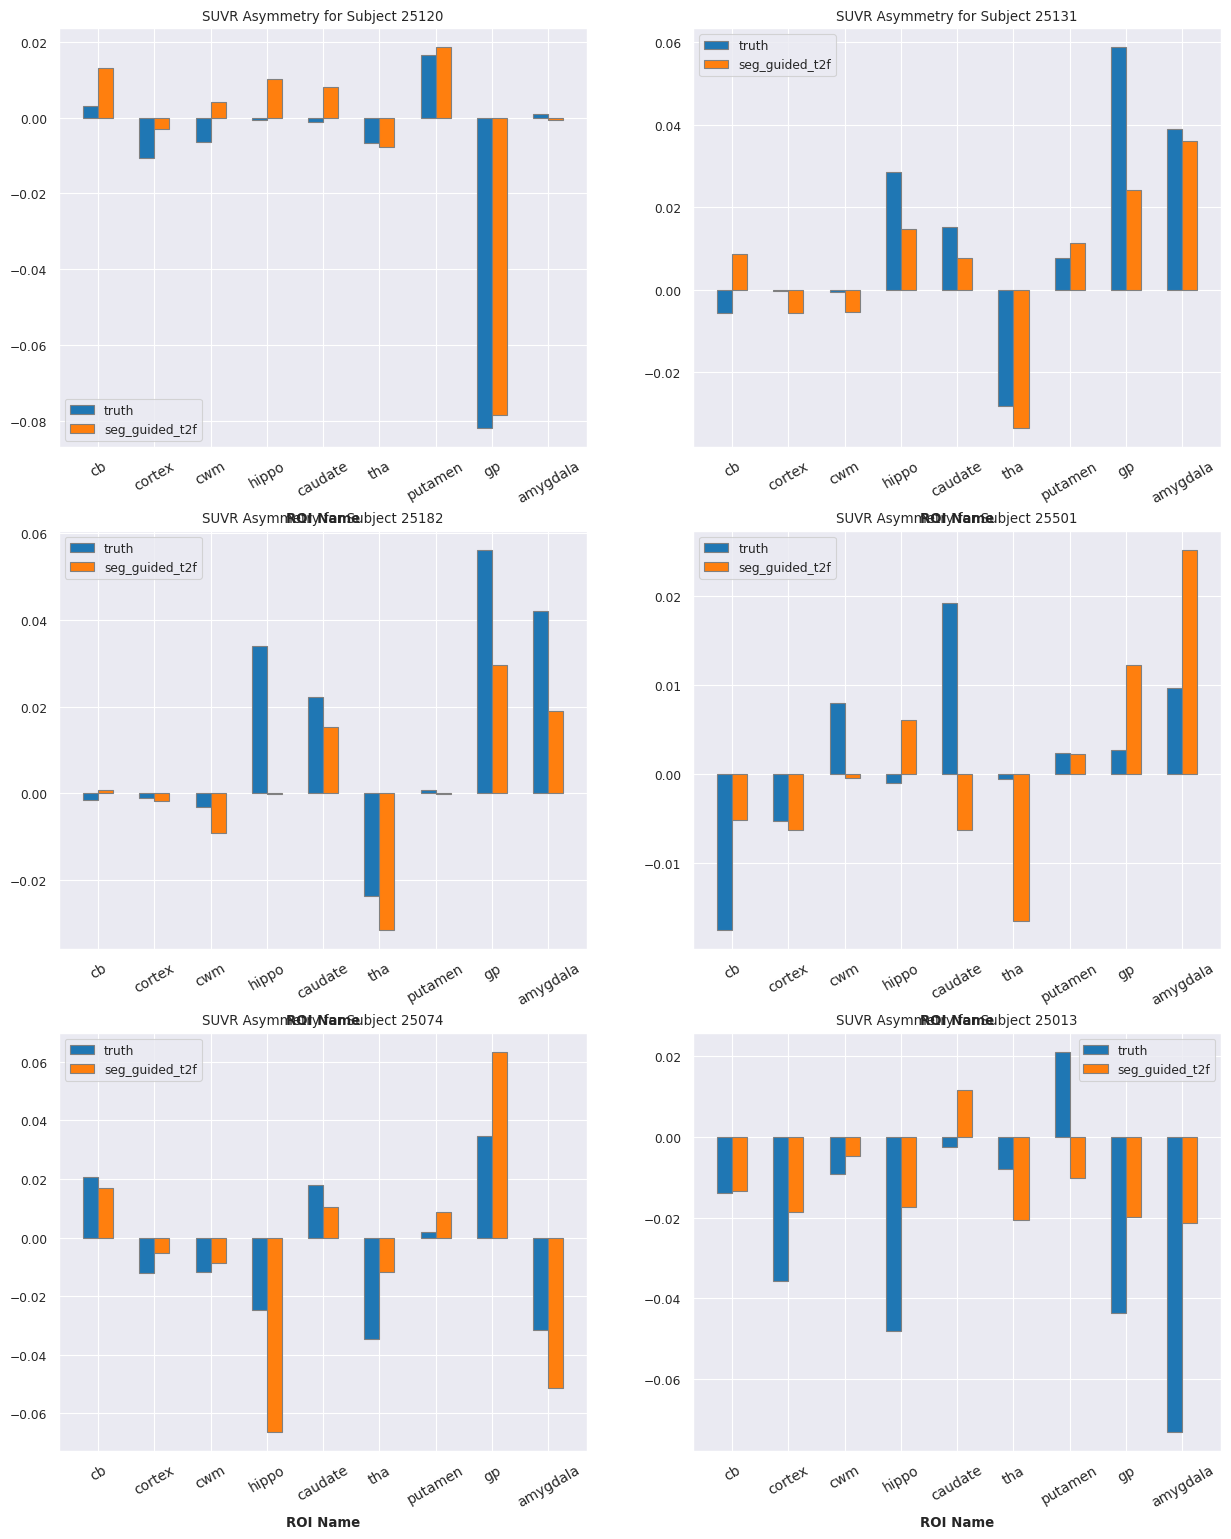

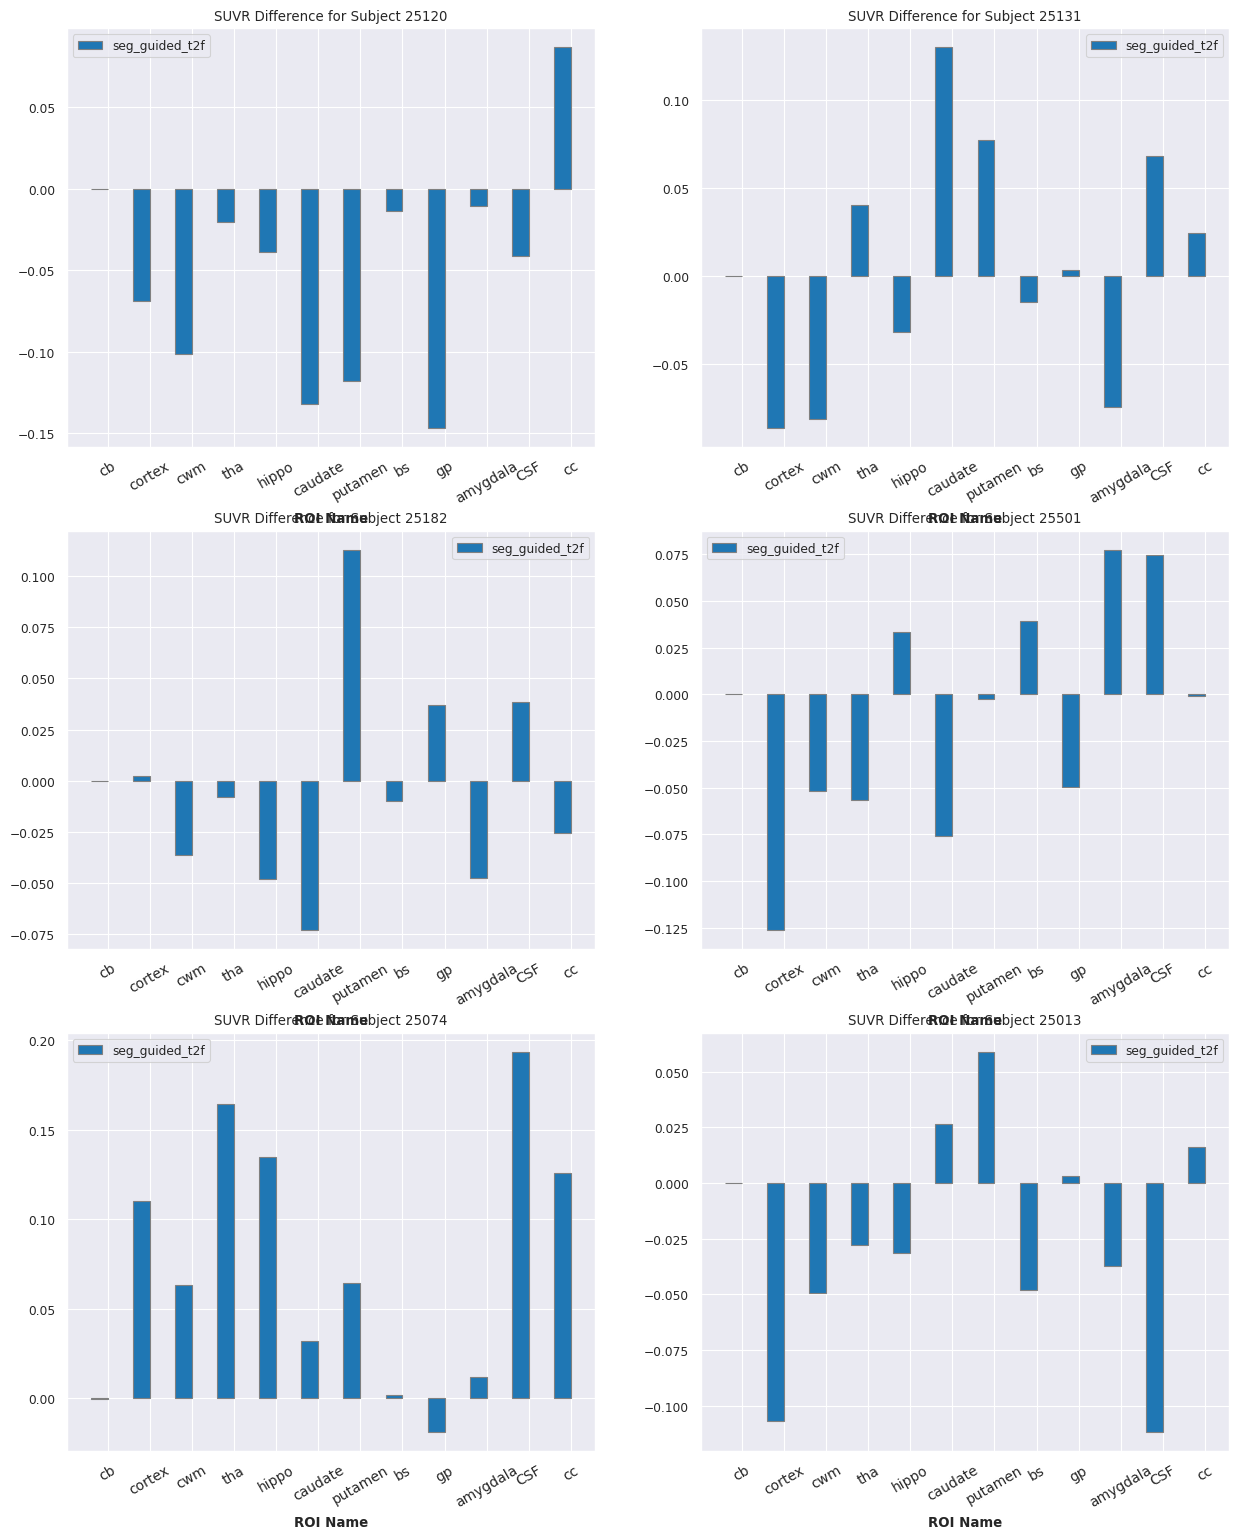

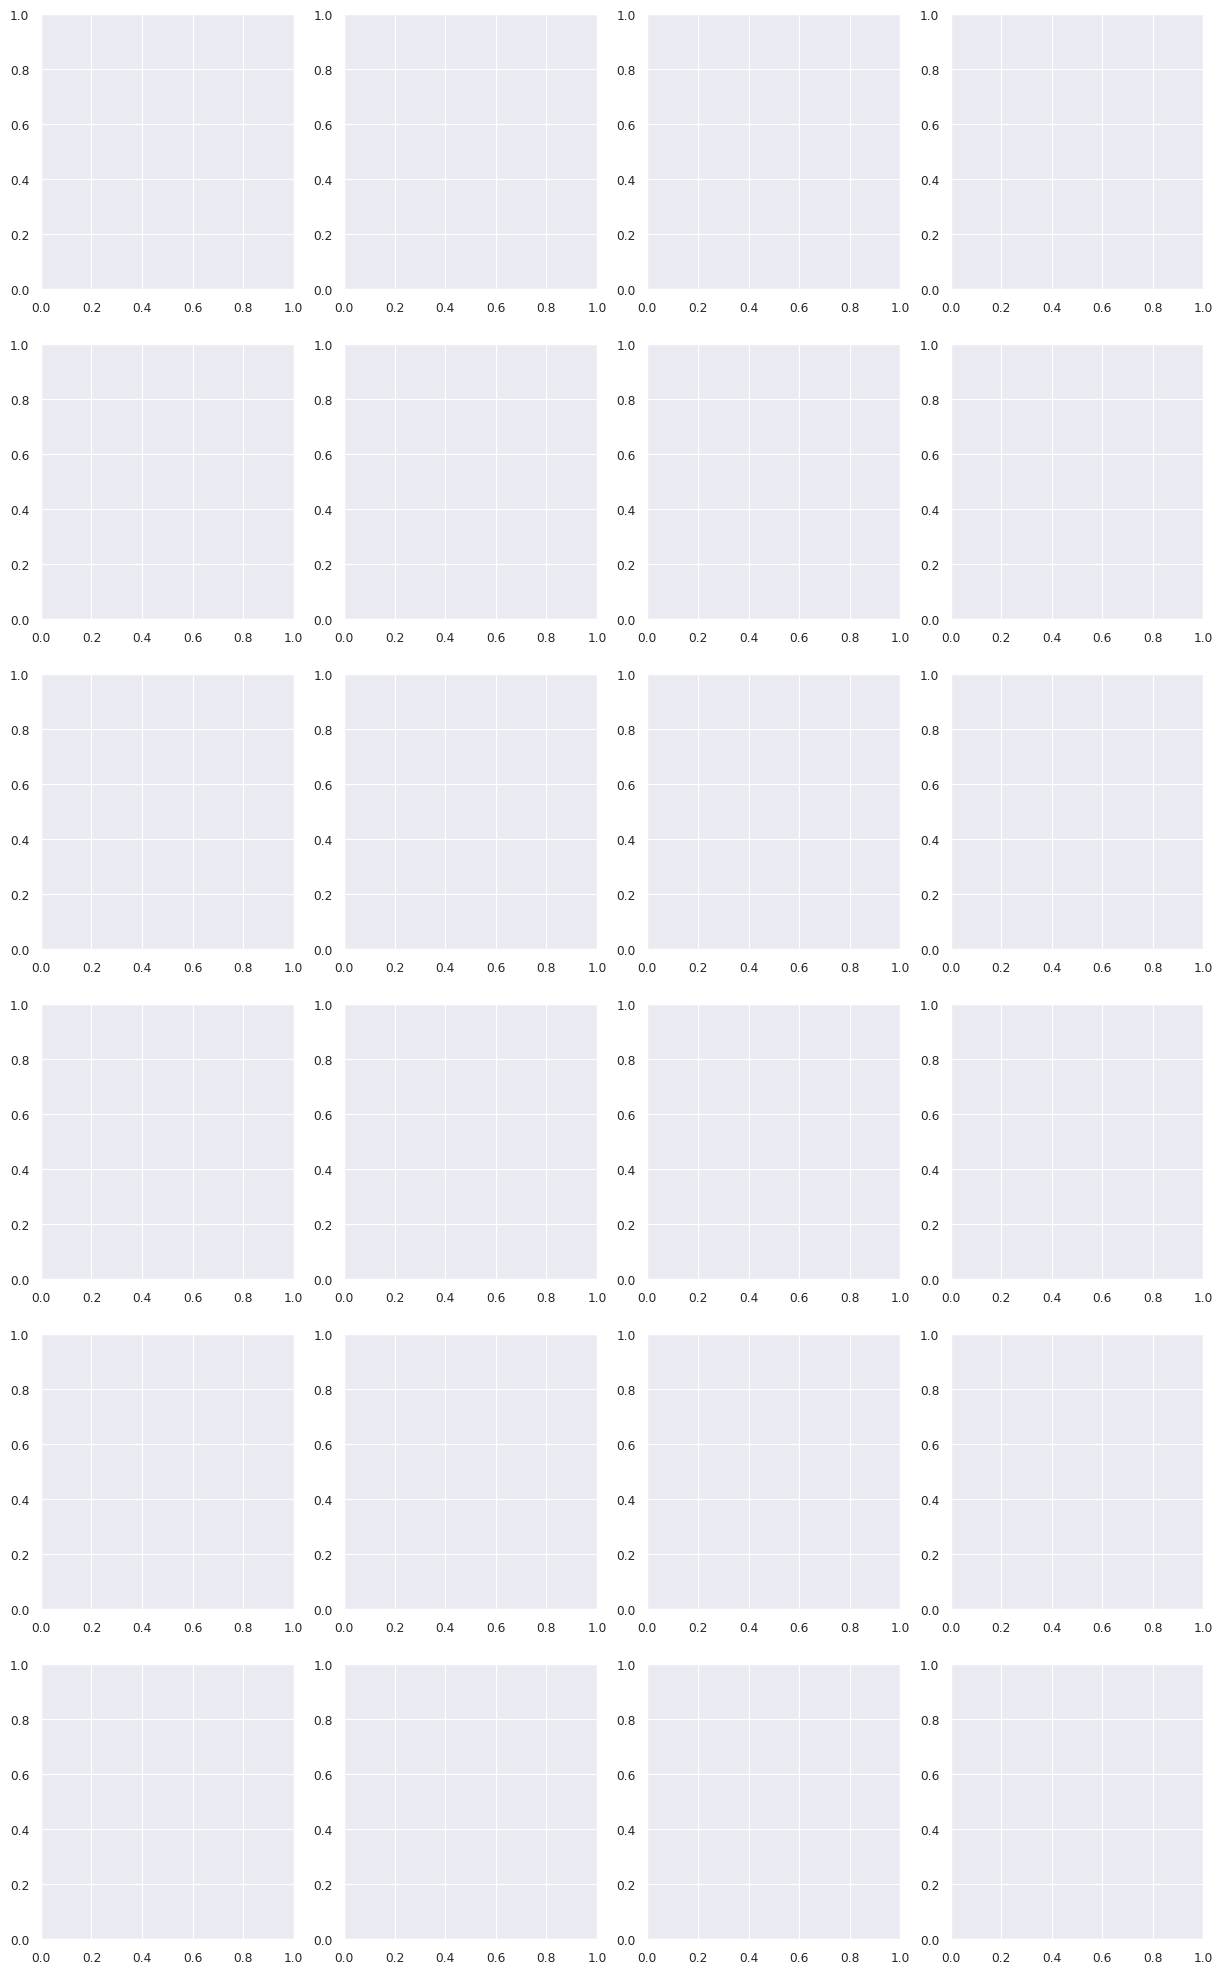

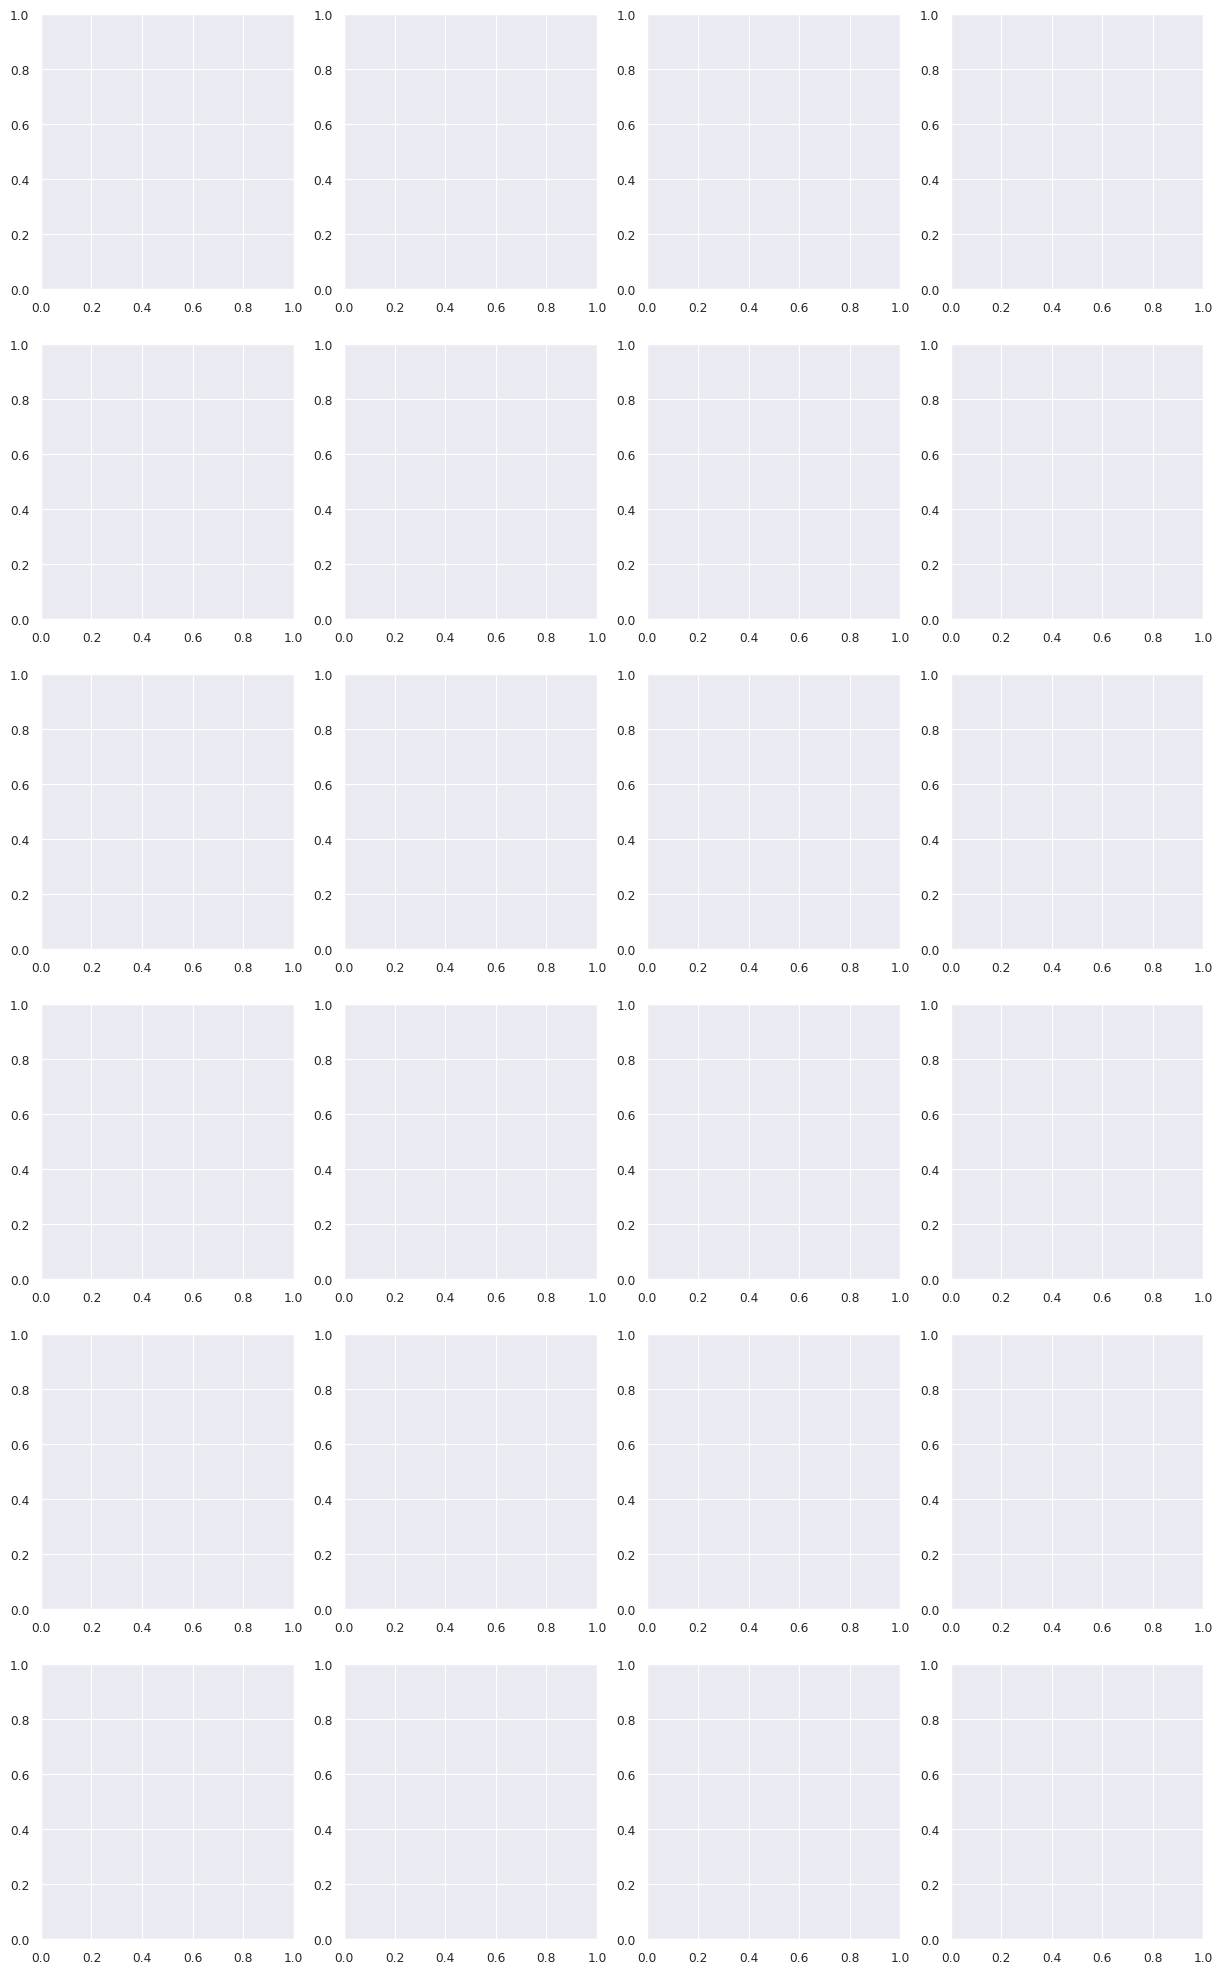

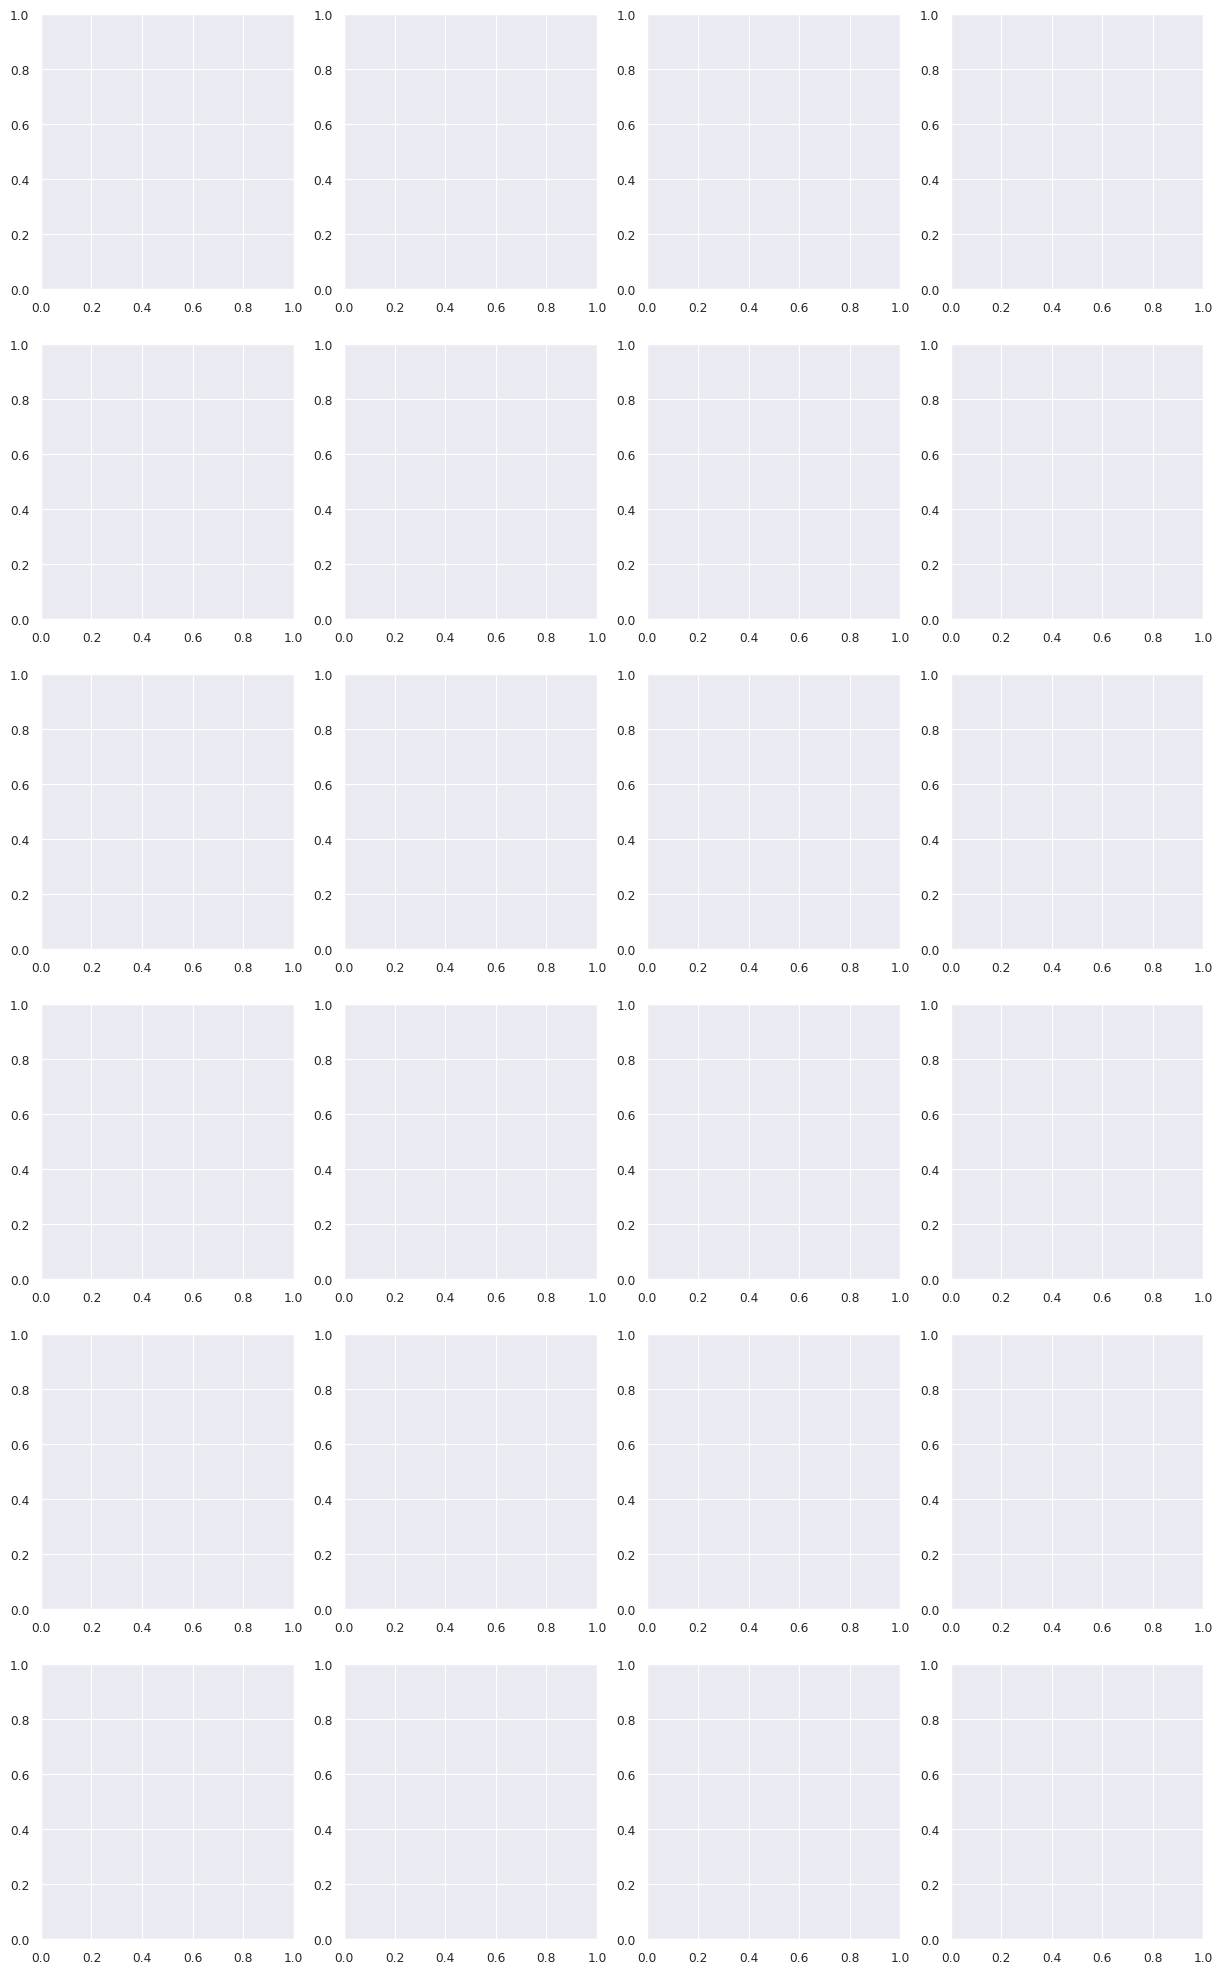

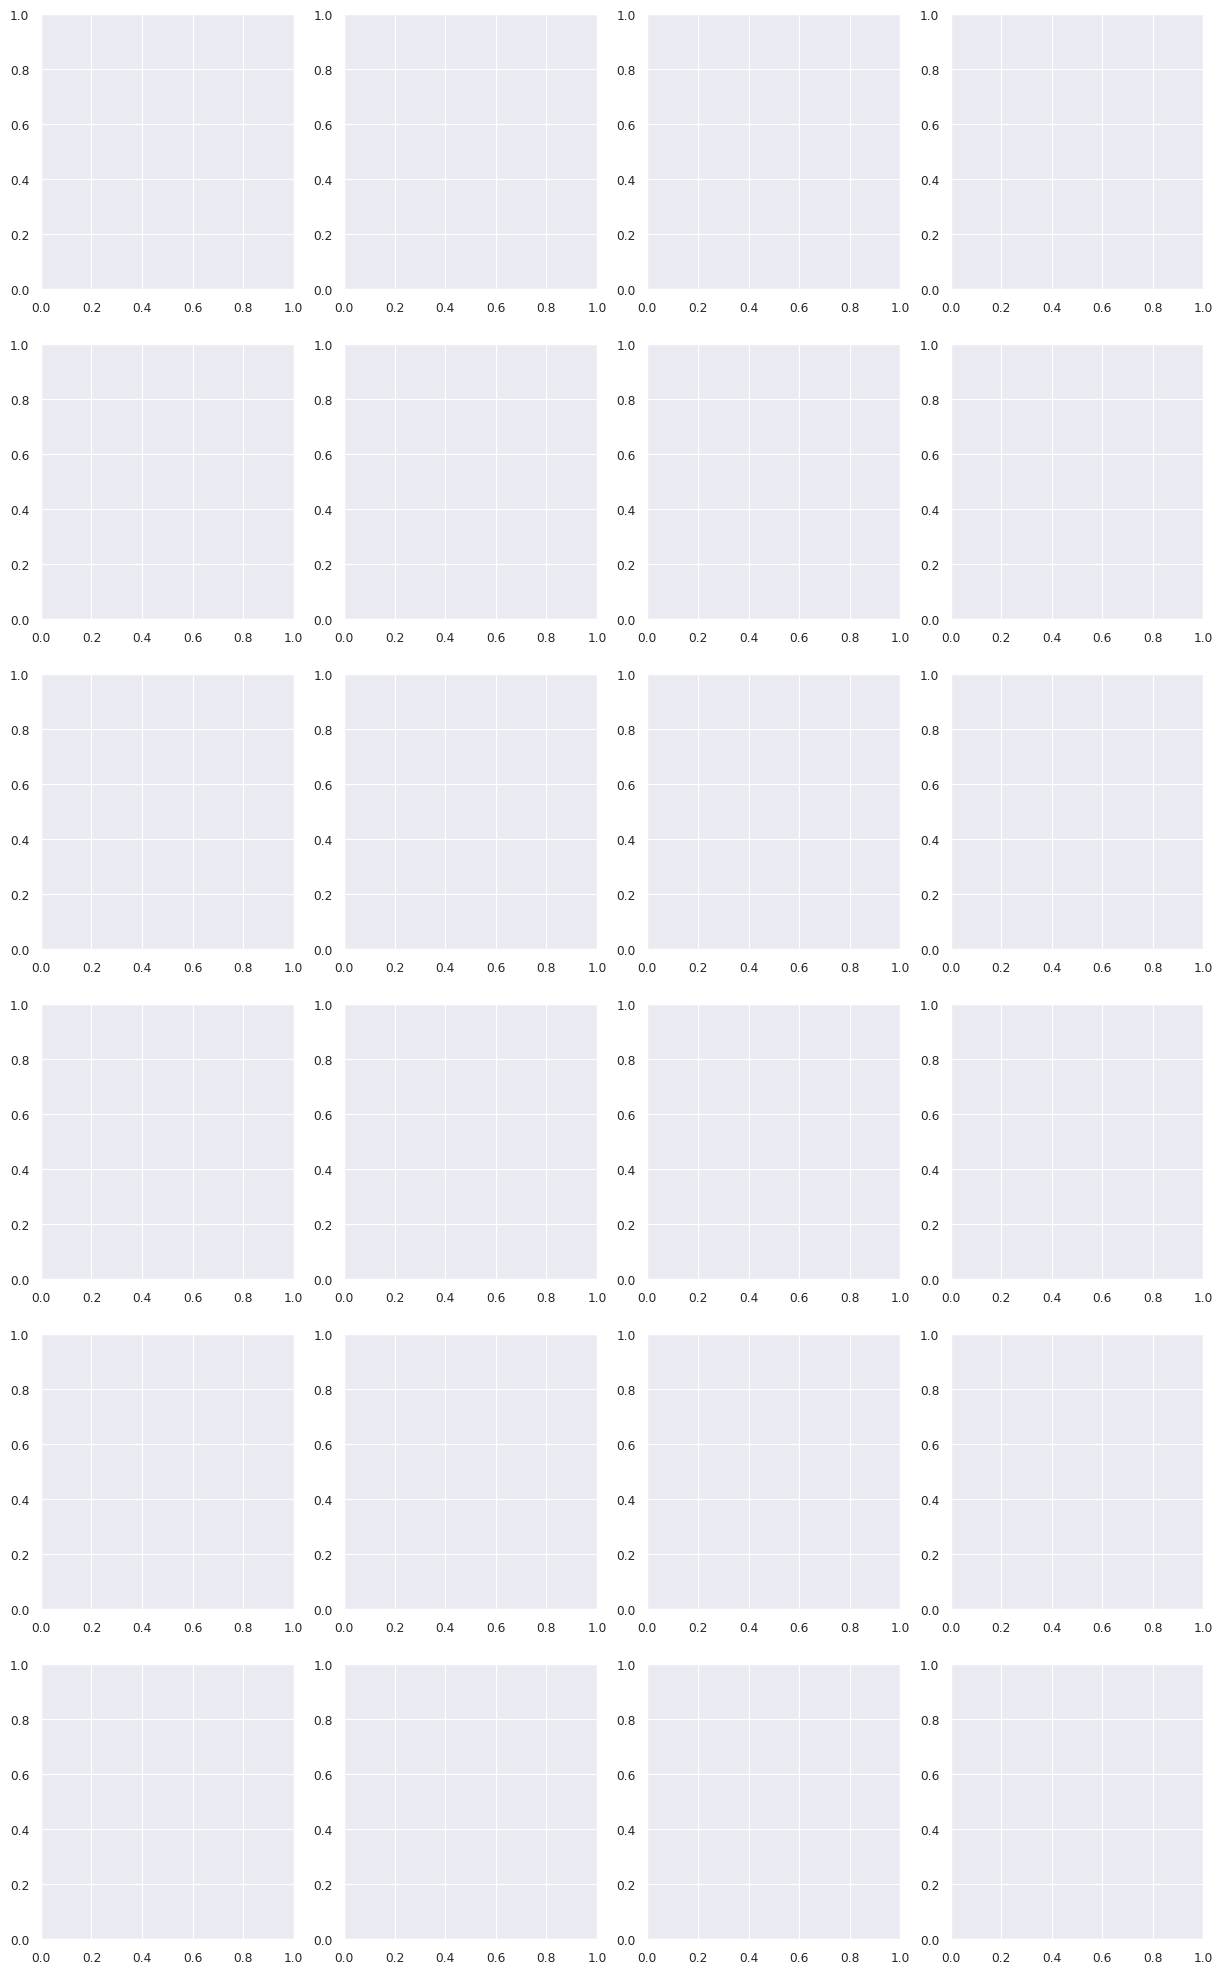

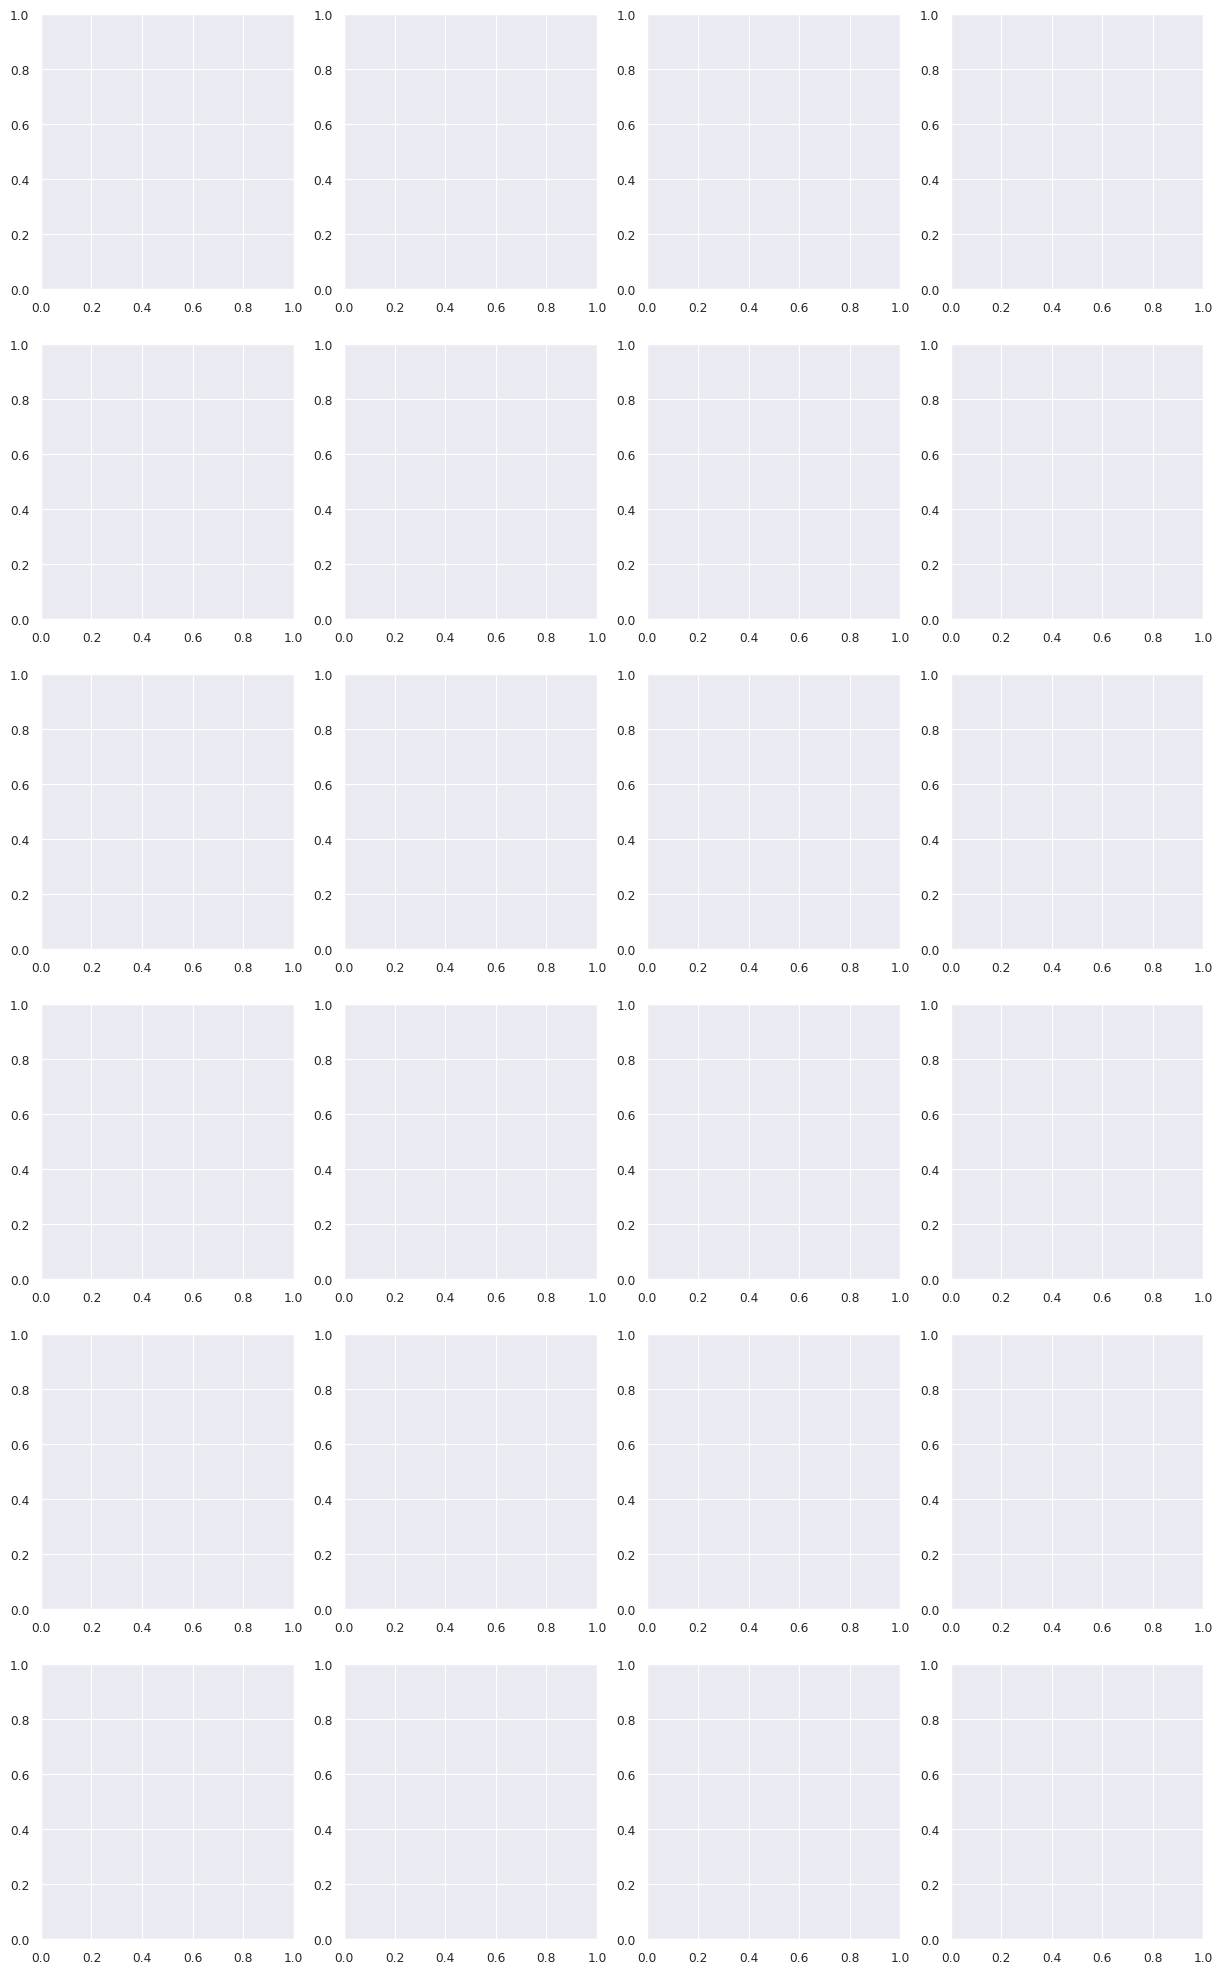

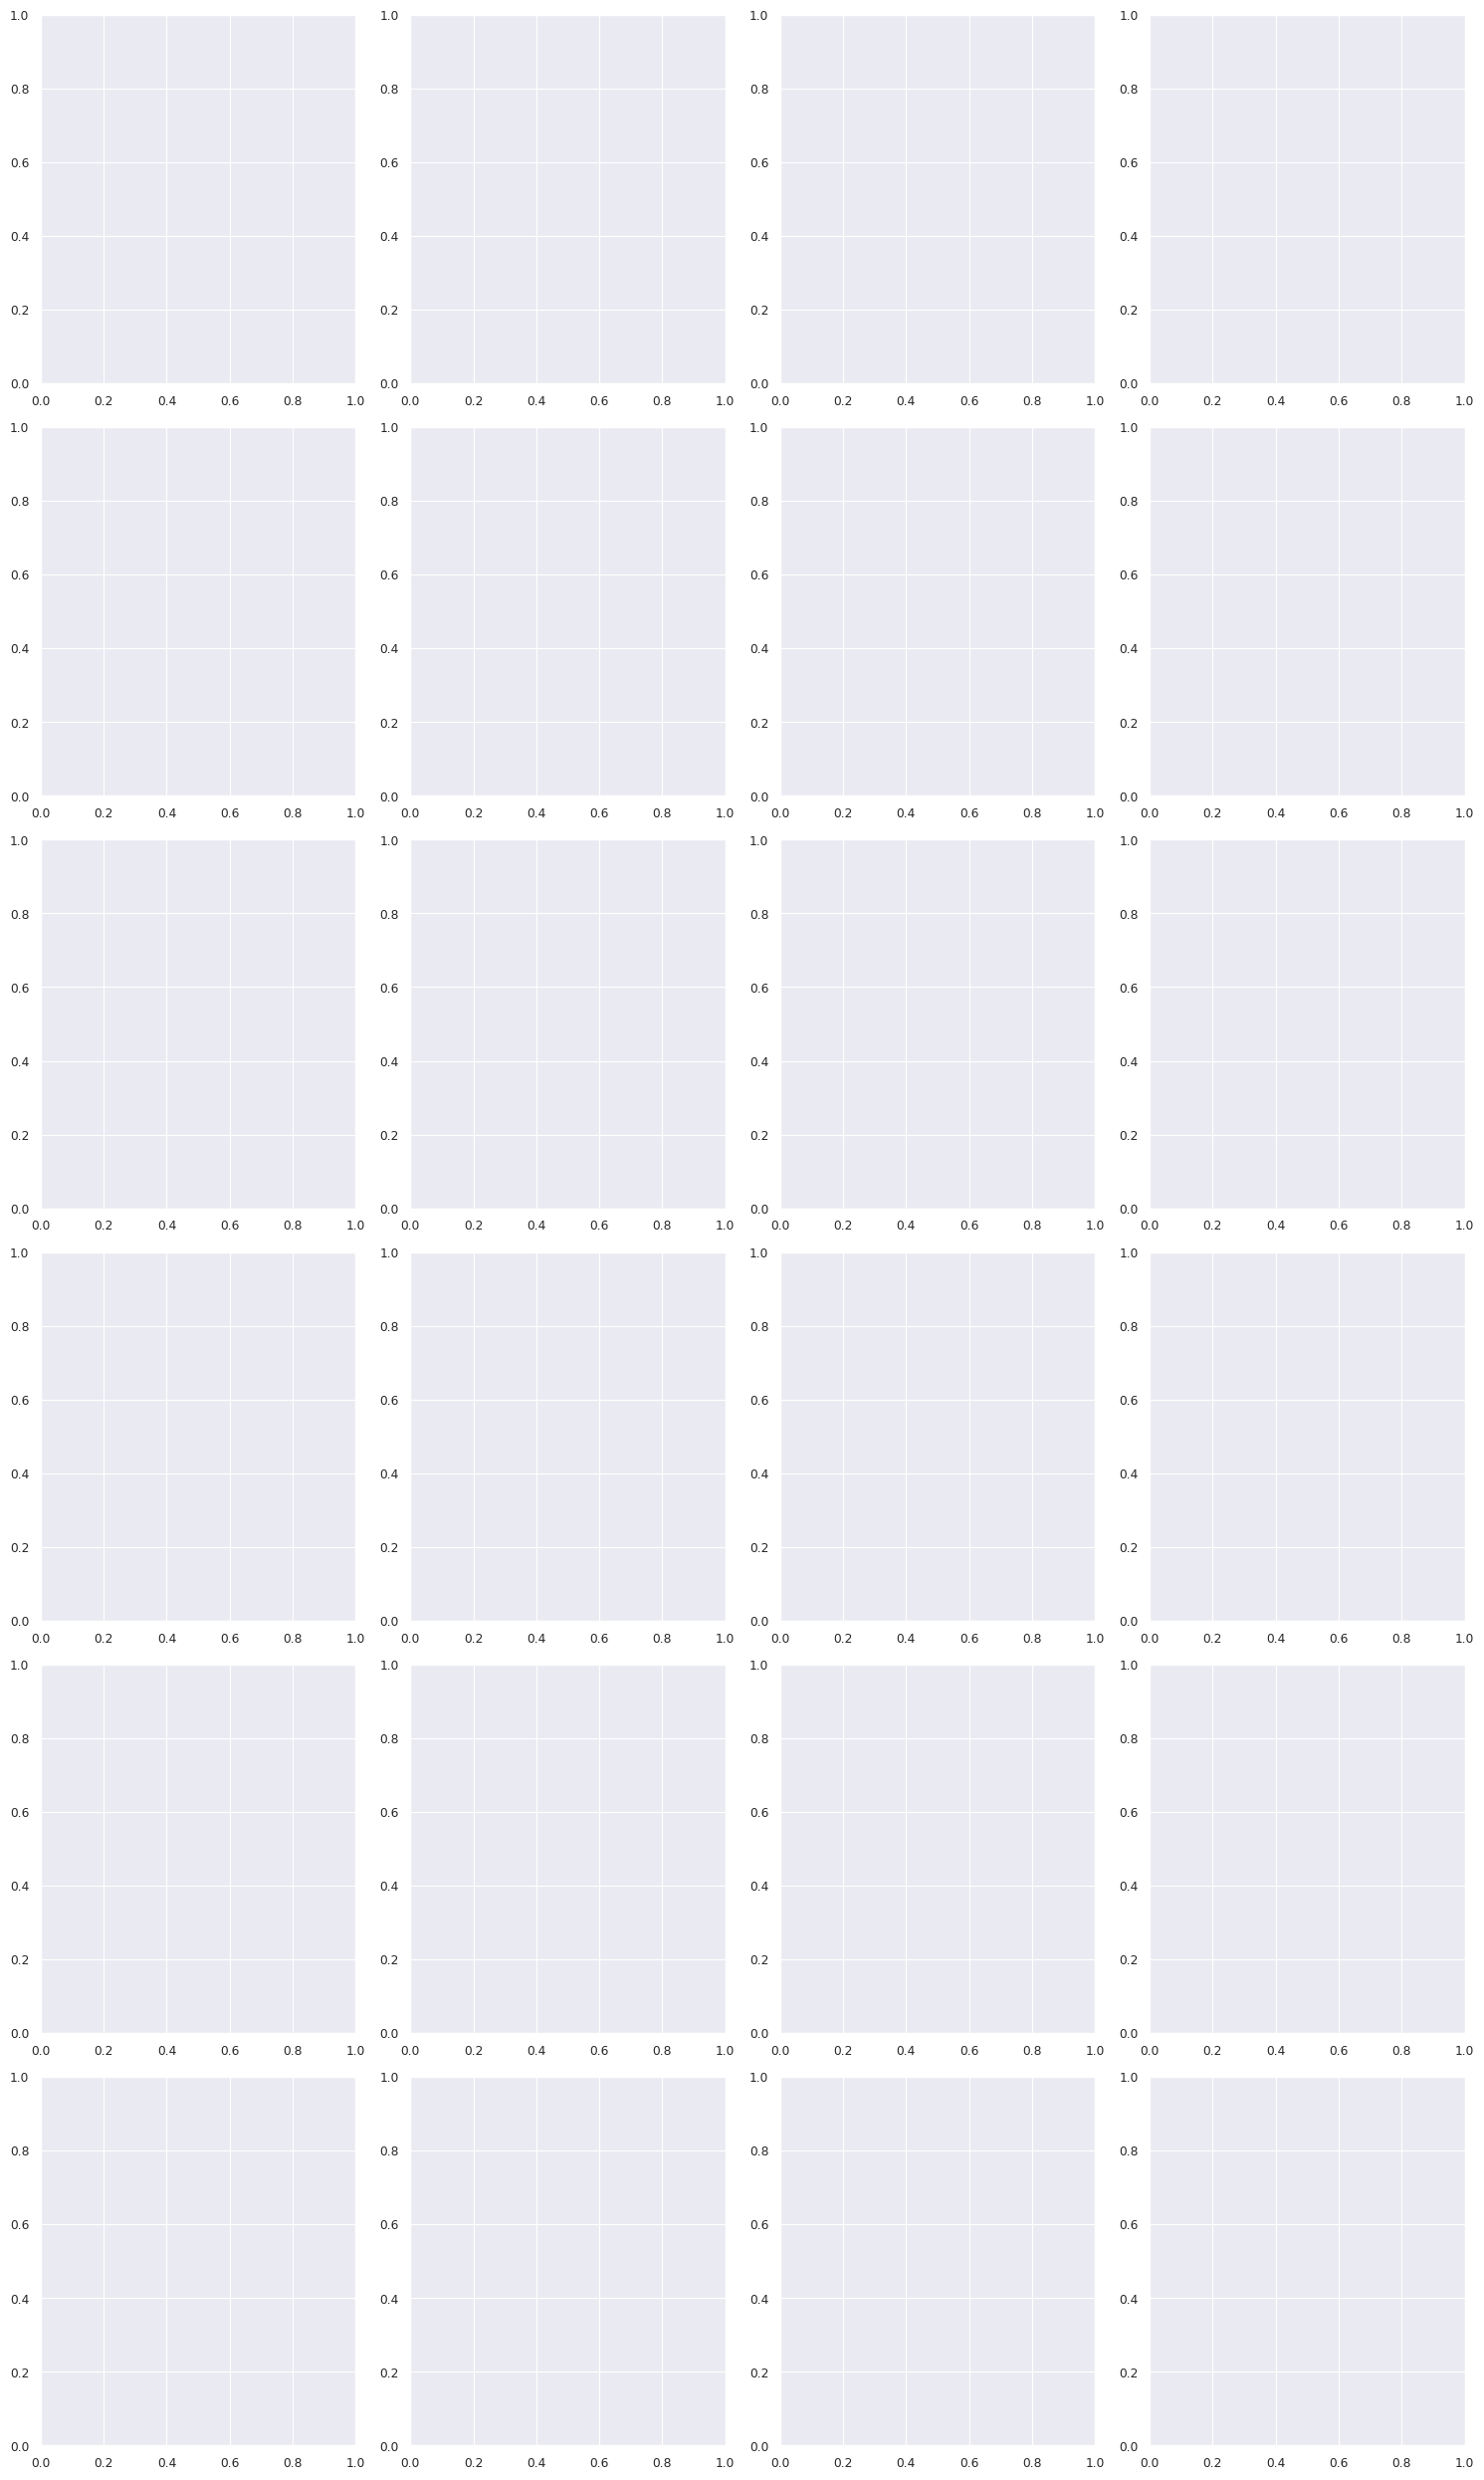

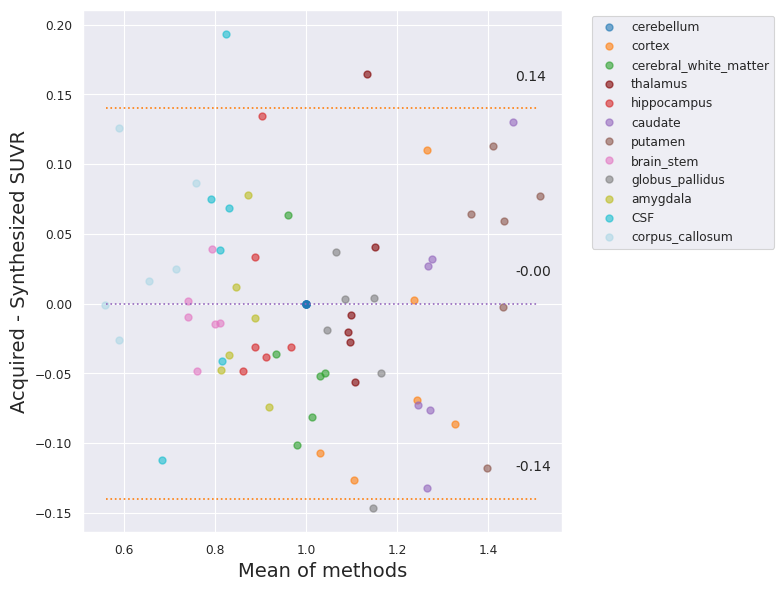

In [178]:
dest=None
test_dirs = [test_dir]
exp_types = [exp_type]
mutual_subjects = collect_mutual_subjects(test_dirs)
combined_suvr_df, combined_asym_df, combined_emd_diff, all_subj_metrics, all_subj_suvr_diff = prepare_all_subjects(mutual_subjects, test_dirs, exp_types, dest)
print("===== Global Bland Altman For SUVR ======")
global_bland_altman(combined_suvr_df, '_suvr', exp_type, 'truth', TARGET_ROIS, save_dest+'/suvr_global_altman.png')

In [114]:
combined_asym_df

,subject,pet_type,cerebellum_left,cerebellum_right,cerebellum_diff,cortex_left,cortex_right,cortex_diff,cerebral_white_matter_left,cerebral_white_matter_right,...,thalamus_diff,putamen_left,putamen_right,putamen_diff,globus_pallidus_left,globus_pallidus_right,globus_pallidus_diff,amygdala_left,amygdala_right,amygdala_diff
0,25120,truth,1.002587,0.996493,0.003048,1.196229,1.222017,-0.010664,0.922553,0.934326,...,-0.006829,1.359717,1.315444,0.016550,0.987855,1.163663,-0.081713,0.882801,0.881243,0.000883
1,25120,vesde_t1_t2f,1.018031,0.978680,0.019708,1.245717,1.242775,0.001182,1.105689,1.074937,...,0.022693,1.344389,1.311944,0.012214,0.983388,1.110251,-0.060595,0.912572,0.861367,0.028865
2,25131,truth,0.994114,1.005503,-0.005696,1.284778,1.285739,-0.000374,0.971304,0.972460,...,-0.028337,1.566173,1.542253,0.007695,1.226478,1.090258,0.058798,0.921194,0.852251,0.038875
3,25131,vesde_t1_t2f,1.000248,0.999410,0.000419,1.333802,1.361629,-0.010324,1.161389,1.164860,...,-0.030195,1.442224,1.382075,0.021297,1.061887,1.038525,0.011122,0.987383,1.030760,-0.021493
4,25182,truth,0.998325,1.001162,-0.001419,1.237912,1.240656,-0.001107,0.913551,0.919484,...,-0.023603,1.469509,1.466925,0.000880,1.146466,1.024378,0.056240,0.828313,0.761311,0.042150
5,25182,vesde_t1_t2f,1.002505,0.997368,0.002569,1.158936,1.159507,-0.000246,0.978563,0.990015,...,-0.005003,1.235402,1.214929,0.008355,0.875245,0.874695,0.000315,0.840473,0.827033,0.008060
6,25501,truth,0.982871,1.017857,-0.017487,1.036574,1.047558,-0.005270,1.012268,0.996169,...,-0.000532,1.435964,1.429108,0.002393,1.142794,1.136586,0.002724,0.921207,0.903538,0.009683
7,25501,vesde_t1_t2f,0.984998,1.015674,-0.015333,1.144784,1.167848,-0.009973,1.196184,1.202410,...,-0.001984,1.479465,1.470770,0.002947,1.145357,1.175970,-0.013188,0.932381,0.882979,0.027214
8,25074,truth,1.020459,0.979447,0.020507,1.304893,1.336917,-0.012122,0.980996,1.004348,...,-0.034546,1.397662,1.391889,0.002069,1.075780,1.003408,0.034808,0.816388,0.869591,-0.031556
9,25074,vesde_t1_t2f,1.016866,0.983136,0.016865,1.213160,1.221897,-0.003588,1.038349,1.032930,...,-0.000809,1.377925,1.224264,0.059051,1.010314,0.873372,0.072699,0.841939,0.844712,-0.001644


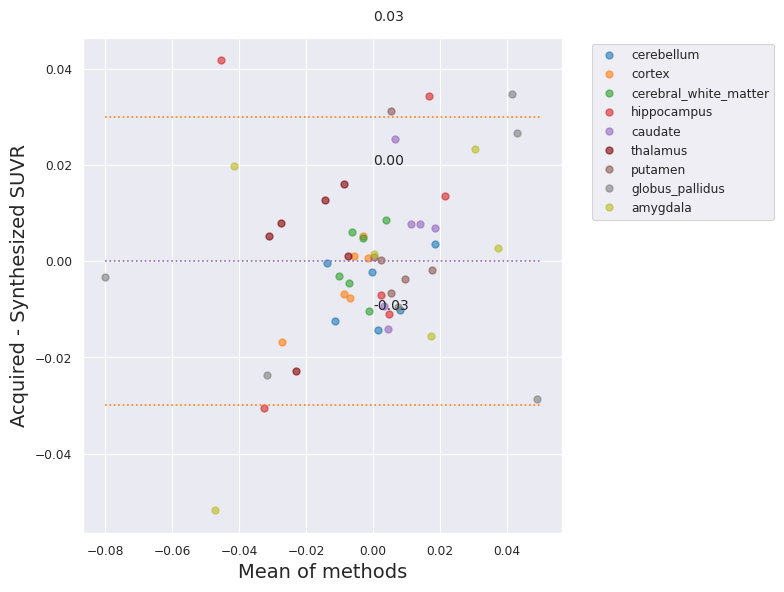

In [179]:
global_bland_altman(combined_asym_df, '_diff', exp_types[0], 'truth', LR_ROIS, save_dest+'/suvr_asym_global_altman.png')